## Mapping the _P. aeruginosa_ cell surface with Phage-seq (`fig-mapping`)



Note: This notebook trains the models and generates the panels of this figure which show receiver operator characteristic curves as well as the class label balance. The panels showing ordination are in a [separate notebook `fig-mapping.ipynb`](./fig-mapping.ipynb).

Important: due to slightly different scipy and XGBoost versions at the time these models were originally generated, this notebook requires the conda environment [`nbseq-xgb`](../envs/nbseq-xgb.yaml) to load the published models.

In [1]:
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
from importlib import reload

import os.path
import pandas as pd, numpy as np
import scipy.stats
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import *
from anndata import AnnData

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*FutureWarning: pandas.Int64Index is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*FutureWarning: pandas.core.index is deprecated.*")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    from pandas import MultiIndex
    import xgboost as xgb

In [4]:
# silence xgboost deprecation warnings and numerous irrelevant warnings from matplotlib
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [5]:
from nbseq.utils import *
import nbseq.ft
import nbseq.pheno
import nbseq.select
import nbseq.utils
import nbseq.design
import nbseq.predict
import nbseq

In [6]:
plt.rcParams.update({
    "font.family":"sans",
    "font.size": 6,
    "svg.fonttype": "none"
})

FONT_SIZE = 5

In [7]:
%config InlineBackend.figure_formats = ['svg']

## Summarize XGBoost Classifier optimization

Snakemake workflows fitted and evaluated models using various hyperparameters using several strategies. Review the results and identify the best-performing hyperparameters overall.

***

In [8]:
import pickle
with open('results/learning/designs.pickle', 'rb') as file:
    designs = pickle.load( file )

In [9]:
import pickle
with open('results/learning/ag_matrix.pickle', 'rb') as file:
    ag_matrix = pickle.load( file )

***

In [10]:
def plot_roc(cv_out, aggregate_folds=False, ax=None, title=None, verbose=False, legend=True, show_accuracy=False, fig_kw=None):
    from sklearn.metrics import RocCurveDisplay, auc
    from scipy.stats import ttest_1samp
    from scipy.stats import mannwhitneyu

    if ax is None:
        if fig_kw is None:
            fig_kw = dict()
        fig, ax = plt.subplots()
    else:
        fig = None

    mean_fpr = np.linspace(0, 1, 100)
    def plot_fold(df, alpha=0.2, label='', **kwargs):

        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore")
        if label is not None:
            kwargs['label'] = label

        viz = RocCurveDisplay.from_predictions(
            df.y,
            df.p_y, 
            alpha=alpha,
            ax=ax,
            # name="_ROC fold {}".format(i),
            # legend=False,
            **kwargs
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        return {'interp_tpr': interp_tpr, 'tpr':viz.tpr, 'fpr':viz.fpr, 'auc':viz.roc_auc } #, 'p': res.pvalue, 'U': res.statistic}
        # tprs.append(interp_tpr)
        # aucs.append(viz.roc_auc)

    if not aggregate_folds:
        tprs = []
        aucs = []

        curves = cv_out.groupby('fold').apply(plot_fold)
        
        tprs = [curve['interp_tpr'] for curve in curves.values]
        aucs = [curve['auc'] for curve in curves.values]

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        if verbose:
            print(f"AUC = {mean_auc:0.2f} ± {std_auc:0.2f}")
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label="Mean ROC\n(AUC = %0.2f $\\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05]
        )
        
        out = pd.concat([
            pd.DataFrame({'fold':fold, 'tpr':curve['tpr'],'fpr':curve['fpr'], 'auc':curve['auc']}) 
            for fold, curve in curves.items()
        ] + [
            pd.DataFrame({'fold':'mean', 'tpr':mean_tpr, 'fpr':mean_fpr, 'auc': mean_auc})
        ])
    else:
        out = pd.DataFrame(plot_fold(cv_out, label=None, alpha=1))[['tpr','fpr','auc']]

    pvalue = ttest_1samp(cv_out.score, popmean=0.5, alternative='greater').pvalue

    # calculate P(AUROC > 0.5); equivalent to asking whether the median predicted probability
    # for positive samples (y=1) is greater than the median predicted probability for 
    # negative samples (y=0). This is the question asked by the Mann-Whitney U test, where 
    # AUROC = U1/n1*n2 so we can use `mannwhitneyu` to calculate the p-value
    (pos_idx,) = np.nonzero(cv_out.y.values)
    (neg_idx,) = np.nonzero(~cv_out.y.values)
    
    res = mannwhitneyu(cv_out.p_y.iloc[pos_idx], cv_out.p_y.iloc[neg_idx], alternative='greater')
    pvalue_auc = res.pvalue
    out['p'] = pvalue_auc
    out['U'] = res.statistic
    
    mean_acc = cv_out['score'].mean()
    std_acc = cv_out['score'].std()
    
    if verbose:
        print(f"  AUC < 0.5, p = {pvalue_auc:0.8g} (U = {res.statistic:0.8g}; Mann-Whitney U, alternative = greater)")
        print(f"Accuracy = {cv_out['score'].mean():0.2g} ± {cv_out['score'].std():0.2g}")
        print(f"  accuracy < 0.5, p = {pvalue:0.8g} (t-test, alternative = greater)")
        

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")

    label = (f"AUC = {mean_auc:0.2f} ± {std_auc:0.2f}\n"
         f"p = {pvalue_auc:0.1g}")
    if show_accuracy:
        label += ("\n"
                  f"accuracy = {mean_acc:0.2g} ± {std_acc:0.2f}\n" 
                  f"p = {pvalue:0.1g}")
    
    if title is not None:
        ax.set_title(title)
        
    if legend==True:
        ax.legend(loc="lower right")
    elif legend=='text':
        ax.get_legend().remove()
        ax.text(0.95, 0.05, 
                label, horizontalalignment='right', verticalalignment='bottom', 
                transform = ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, linestyle=''))
    elif legend=='both':
        ax.legend(loc="lower right")
        
        label = f"        AUC < 0.5, p = {pvalue_auc:0.1g}"
        if show_accuracy:
            label += f"\n accuracy < 0.5, p = {pvalue:0.1g}"
        ax.text(0.05, 0.95, 
                label,
                horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    
    if fig is not None:
        fig.show()

    return out

In [11]:
from nbseq.design import get_design_for_ag
from nbseq.predict import cross_val_multi_predict

def fit_and_test_model_antigen(design, ag_matrix, ag, 
                               model = xgb.XGBClassifier(use_label_encoder=False, **{'eval_metric':'logloss'}), 
                               auto_scale_pos_weight=None,
                               shuffle=False,
                               plot=True, plot_minimal=True, aggregate_folds=True, ax=None, plot_kws = None,
                               # predict = lambda model, X_test: np.around(model.predict(X_test)), 
                               verbose=True,
                               **kwargs):
    
    from sklearn import clone    
    from sklearn.metrics import roc_auc_score
    from textwrap import indent
    
    train_idx, X_train, X_unknown, y = get_design_for_ag(design, ag_matrix, ag, shuffle=shuffle)
    
    if auto_scale_pos_weight is None:
        auto_scale_pos_weight = isinstance(model, xgb.XGBClassifier)
    if auto_scale_pos_weight:
        model.set_params(scale_pos_weight=(sum(y == 0)/sum(y > 0)))
        
    if verbose:
        print(f"{ag}{f' SHUFFLE {shuffle}' if shuffle else ''} : # samples = ")
        print(indent(y.value_counts().to_string(), "    "))
        if auto_scale_pos_weight: print("(Setting `scale_pos_weight` to sqrt(# neg / # pos))")
        print(model)

    model_unknown = clone(model)
    
    out = cross_val_multi_predict(
        clone(model), 
        X_train, y, 
        methods={
            'y_hat':'predict', 
            'p_y': lambda m, X, y: m.predict_proba(X)[:,1]
        }, 
        verbose=verbose, **kwargs)
    cv_out = pd.DataFrame(out)
    cv_out['score'] = (cv_out['y'] == cv_out['y_hat']).astype(int)
    
    if not aggregate_folds:
        scores = cv_out.groupby('fold').apply(lambda g: sklearn.metrics.roc_auc_score(g['y'], g['p_y'])).rename('roc_auc')
    else:
        scores = pd.Series([roc_auc_score(cv_out['y'], cv_out['p_y'])], name='roc_auc')

    if plot_kws is None:
        plot_kws = dict()
    if plot:
        roc = plot_roc(cv_out, 
                 aggregate_folds=aggregate_folds,
                 title=f"{ag}{(', shuffle ' + shuffle) if shuffle else ''}",
                 verbose=verbose, ax=ax, **plot_kws)
    else:
        roc = None
        
    model_unknown.fit(X_train, y)
    if isinstance(design, AnnData):
        index = design.obs_names[~train_idx]
    else:
        index = design.index[~train_idx]
    y_unknown = pd.Series(model_unknown.predict(X_unknown), index=index, name=ag)
    
    return {'y_unknown': y_unknown, 'model_unknown':model_unknown, 'cv':cv_out, 'scores':scores, 'roc': roc }

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.


In [12]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

In [13]:
from nbseq.viz.utils import trunc_ellipsis
def plot_sample_accuracy(out, ag, obs=None):
    if obs is None:
        obs = ex.obs.drop_duplicates(subset=['name']).set_index('name')
    samples = out['cv'].groupby('index').score.agg(['count','mean','std']).join(obs[['description', ag]]).sort_values('mean')
    samples['description'] = samples['description'].fillna('synthetic control').apply(trunc_ellipsis(100))
    
    colors = np.where((samples[ag] > 0), 'tab:blue', 'tab:orange')
    fig, ax = plt.subplots(figsize=(0.25*len(samples), 4))
    ax.errorbar(x=samples.index, y=samples['mean'], yerr=samples['std'], marker='o')
    # plt.xticks(samples['description']);
    ax.set_xticklabels(samples['description'], rotation=-45, horizontalalignment='left');
    
    for l, color in zip(ax.get_xticklabels(), colors):
        l.set(color=color)
        
    ax.axhline(y=0.5, color='red')
    ax.set_ylim([-0.1,1.1]);
    ax.set_title(f'Sample accuracy: {ag}')
    ax.set_xlabel('sample')
    ax.set_ylabel('mean accuracy')
    
    return samples

In [14]:
def plot_feature_importance_summary(out, ag, design, n_features=None):
    feature_names = design.var_names.values
    
    estimators = out['cv'].groupby('fold')['estimator'].first()
    feature_importances = estimators.apply(lambda model: pd.Series(model.feature_importances_, index=feature_names))
    n_features = (feature_importances > 0).sum(axis=1) #estimators.apply(lambda model: model.feature_importances)
    
    feature_ranks = feature_importances.rank(axis=1, ascending=False)
    
    mfr = feature_ranks.agg(['mean', 'std']).T.sort_values('mean', ascending=True)
    mfi = feature_importances.agg(['mean', 'std']).T.sort_values('mean', ascending=False)
    
    fig, axs = plt.subplots(nrows=3, figsize=(8, 12))
    
    sns.histplot(data=n_features, ax=axs[0])
    axs[0].set_xlabel('# features in model')
    axs[0].set_ylabel('# folds')
    
    if n_features is None:
        from kneed import KneeLocator
        n_features = KneeLocator(x=range(len(mfi)), y=mfi['mean'], curve='convex', direction='decreasing').knee + 10
        
    # xlim = sum(mfi['mean'] > 0)
    
    top_feature_ranks       = mfr.iloc[:n_features,:]
    top_feature_importances = mfi.iloc[:n_features,:]
    
    
    
    axs[1].errorbar(x=range(len(top_feature_ranks['mean'])), y=top_feature_ranks['mean'], yerr=top_feature_ranks['std'])
    
    axs[1].set_xticks(list(range(len(top_feature_ranks['mean']))))
    axs[1].set_xticklabels(top_feature_ranks.index.values, rotation=-45, horizontalalignment='left')
    axs[1].set_ylabel('mean feature rank')
    
    axs[2].errorbar(x=range(len(top_feature_importances)), y=top_feature_importances['mean'], yerr=top_feature_importances['std'])
    axs[2].set_xticks(list(range(len(top_feature_importances))))
    axs[2].set_xticklabels(top_feature_importances.index.values, rotation=-45, horizontalalignment='left')
    axs[2].set_ylabel('mean feature importance')
    
    return mfr, mfi

In [15]:
# get some data to use for this exercise
# train_idx, X_train, X_unknown, y = get_design_for_ag(designs['CDR3:enr'], ag_matrix, ag='FliC', shuffle=False)

In [16]:
from nbseq.viz.utils import plot_grid

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [18]:
from plotnine import *
def plot_best_scores_by_ag_design(df, groupby='design'):
    df = df.copy()
    df['design'] = pd.Categorical(df['design'], categories=datasets, ordered=True)
    df['antigen'] = pd.Categorical(df['antigen'], categories=antigens, ordered=True)
    if groupby == 'design':
        color = 'antigen'
        palette='Paired'
    else:
        color='design'
        palette='Set1'
    dodge = position_dodge(width=0.7)
    
    return (ggplot(df, aes(x=groupby, y='mean_test_score', 
                           ymax='mean_test_score+std_test_score', 
                           ymin='mean_test_score-std_test_score',
                           color=color, fill=color)) +
            scale_color_brewer(type='qual',palette=palette, aesthetics=['color', 'fill']) +
            # geom_col(position=dodge) + 
            geom_point(position=dodge) + 
            # geom_errorbar(position=dodge, color='black') + 
            geom_errorbar(position=dodge) + 
            geom_hline(yintercept=0.5, color='red') + 
            scale_y_continuous(name='mean AUC ROC') +
            # coord_cartesian(ylim=[0.4, 1.05]) +
            theme(axis_text_x=element_text(rotation=-45, hjust=0)) #, figure_size=(10,10))
           )

In [19]:
def plot_best_scores_by_ag_design2(df):

    dfi = df.reset_index()
    # pivot the data
    dfp = dfi.pivot_table(index='design', columns='antigen', values='mean_test_score', sort=False)
    # pivot the error
    yerr = dfi.pivot_table(index='design', columns='antigen', values='std_test_score', sort=False)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    dfp.plot.bar(yerr=yerr, width=0.8, ax=ax, sort_columns=False)
    ax.legend(bbox_to_anchor=(1.2,1), loc='upper right')
    ax.axhline(y=0.5, color='red')
    ax.set_ylim([0, 1.1]);
    return ax

In [20]:
from plotnine import *
def plot_best_score_heatmap(df):
    df['label'] = df['mean_test_score'].apply('{:.2g}'.format) + ' ± ' + df['std_test_score'].apply('{:.1g}'.format)
    return (ggplot(df, aes(x='antigen', y='design')) 
     + geom_tile(aes(fill='mean_test_score')) 
     + geom_point(aes(fill='mean_test_score+std_test_score'), stroke=0, size=5, position=position_nudge(y=+0.2))
     + geom_point(aes(fill='mean_test_score-std_test_score'), stroke=0, size=5, position=position_nudge(y=-0.2))
     + geom_text(aes(label='label'), size=6, color='white')
     + scale_y_discrete(limits=datasets)
     + scale_fill_continuous(limits=(0.45, 1), name='test_score')
     + theme(figure_size=(11, 5))
     # + scale_fill_distiller(type='div', palette='Spectral', limits=(0.5, 1))
    )

In [21]:
import math
def plot_param_heatmap(df, ncols=3, columns=None, subplot_size=(11,5)):
    if columns is None:
        columns = list(df.columns[df.columns.str.startswith('param_')])
        if len(columns) == 0:
            columns = list(df.columns)
    nrows = math.ceil(len(columns)/ncols)
    if not isinstance(subplot_size, tuple):
        subplot_size = (subplot_size, subplot_size)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*subplot_size[0], nrows*subplot_size[1]))
    for i, col in enumerate(columns):
        ax = axs.flat[i]
        sns.heatmap(
            df[[col]].reset_index().pivot_table(columns='antigen', index='design', values=col),
            annot=True,
            ax=ax
        )
        ax.set_title(col)

In [22]:
def plot_all_params(df):
    dodge = position_dodge(width=0.7)
    return (ggplot(df, aes(x='rank_test_score', y='mean_test_score', 
                    ymax='mean_test_score+std_test_score', 
                    ymin='mean_test_score-std_test_score',
                    color='strategy'
                   )) +
     facet_grid(('antigen', 'design')) +
     # scale_color_brewer(type='qual',aesthetics=['color', 'fill']) +
     geom_point(position=dodge) + 
     geom_errorbar(position=dodge) + 
     geom_hline(yintercept=0.5, color='red') + 
     scale_y_continuous(name='mean AUC ROC') +
     coord_cartesian(ylim=[0.4, 1.05]) +
     theme(figure_size=(10,10))
    )

### Plot antigen class label balance

In [23]:
%%bash
mkdir -p results/plots/learning/
mkdir -p results/tables/figures/learning/

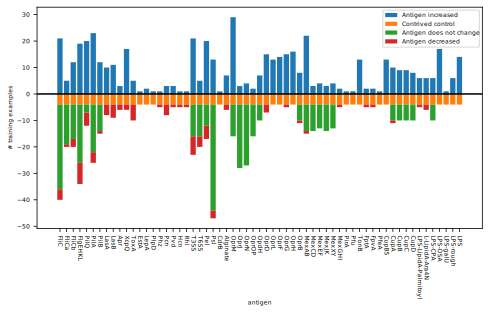

<Figure size 640x480 with 0 Axes>

In [24]:
from nbseq.pheno import plot_antigen_label_balance
fig, ax = plt.subplots(figsize=(8, 4))
n_labels = plot_antigen_label_balance(ag_matrix, ax=ax)
plt.savefig('results/plots/learning/ag_balance.svg')

In [25]:
def tabulate_antigen_balance(ag_matrix):
    control_locs = ag_matrix.index.str.startswith('control_')
    n_controls = control_locs.sum()
    labels = ag_matrix.loc[~control_locs,:]
    
    n_labels = labels.apply(lambda c: c.value_counts())
    n_labels.loc['control',:] = n_controls
    n_labels = n_labels.fillna(0)

    return n_labels.rename(index={
        1.0:'Antigen increased',
        'control':'Contrived control',
        0.0:'Antigen does not change',
        -1.0:'Antigen decreased',
    })

tabulate_antigen_balance(ag_matrix).T.to_csv('results/tables/figures/learning/ag_balance.csv')

In [26]:
n_labels_01 = pd.concat([
    n_labels.loc[n_labels.index != 1,:].sum().rename(0).to_frame(),
    n_labels.loc[n_labels.index == 1,:].T
], axis=1).rename(columns=lambda c: f"n_label_{c:.0f}")

n_labels_01['n_label'] = n_labels_01.sum(axis=1)

In [27]:
datasets = ['CDR3:enr', 'CDR3:R5+enr', 'CDR3:R2345+enr', 'aa:enr', 'aa:R5+enr']
antigens = ['FliC', 'FlgEHKL', 'PilQ', 'T3SS', 'T6SS', 'Pel', 'Psl', 'OprM', 'OprN', 'OprJ', 'CupA', 'CupB']

### Manual optimization of hyperparameters

In [28]:
index = list(itertools.product(datasets, antigens))

manual = {}
best_scores = []
best_params = []
all_params_manual = []
for dataset, ag in index:
    with open(f'results/learning/xgb/manual/{dataset}/{ag}.pickle', 'rb') as f:
        out = pickle.load(f) 
    manual[(dataset, ag)] = out
    best_scores.append(out['summary'].iloc[-1])
    best_params.append(out['best_params'])
    out['summary']['rank_test_score'] = out['summary']['mean_test_score'].rank(ascending=False)
    out['summary']['design'] = dataset
    out['summary']['antigen'] = ag
    all_params_manual.append(out['summary'])

best_scores = pd.DataFrame(best_scores, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
best_params = pd.DataFrame(best_params, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
all_params_manual = pd.concat(all_params_manual)
all_params_manual['strategy'] = 'manual'

Uncomment to visualize performance of all tested hyperparameter combinations, ranked best to worst, for each antigen for each dataset:

In [29]:
# plot_all_params(all_params_manual)

In [30]:
from nbseq.predict import plot_hyperparam_progress
from nbseq.viz.utils import pprint_dict, plot_grid

In [31]:
def plot_hyperparam_progress(summary, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x_labels = summary['new_params'].apply(pprint_dict)
    xs = range(len(x_labels))
    ax.errorbar(xs, summary['mean_test_score'], yerr=summary['std_test_score'])
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels, rotation=-45, horizontalalignment='left');

Uncomment to plot performance of model after each step of manual parameter optimization, with each dataset

In [32]:
# def _plot_hyperparam_opt_ag_dataset(ag, dataset, ax):
#     if (dataset, ag) in manual:
#         summary = manual[(dataset, ag)]['summary']
#         plot_hyperparam_progress(summary, ax=ax)
#         # ax.set_title(",\n".join(str(best_params[(dataset,ag)]).split(",")))
#         ax.set_title(dataset+"\n"+ag)
#         ax.set_ylim([0.45, 1.05])
#         ax.axhline(y=0.5, color='red')
    
# plot_grid(antigens, datasets, _plot_hyperpaaram_opt_ag_dataset, subplot_width=6)

Uncomment to visualize heatmap showing result of various hyperparameters across different datasets

In [33]:
# plot_param_heatmap(best_params, ncols=2, columns=['max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'gamma', 'reg_alpha'])

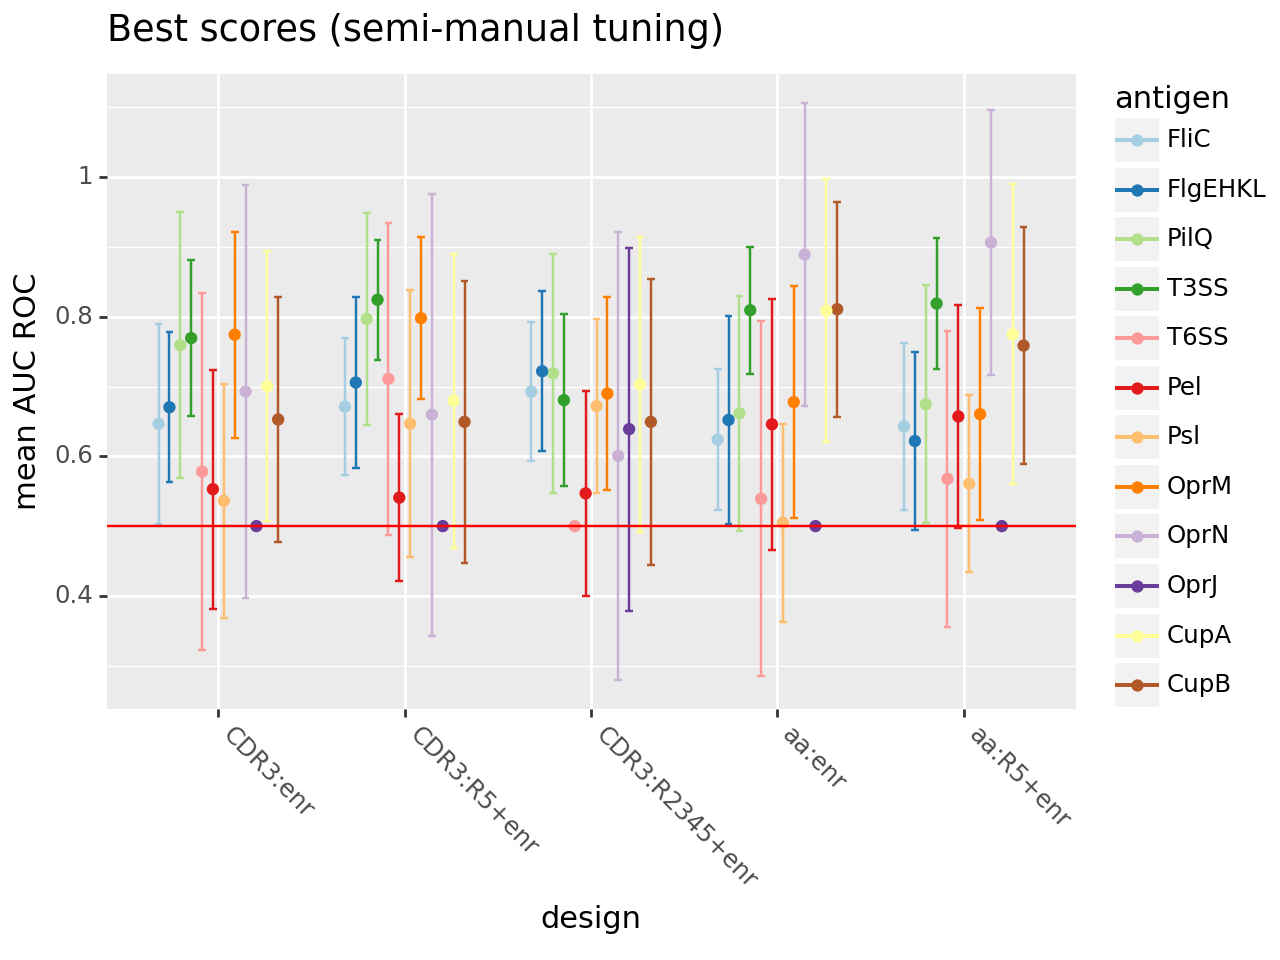

<Figure Size: (640 x 480)>

In [34]:
(plot_best_scores_by_ag_design(best_scores.reset_index()) +
 ggtitle('Best scores (semi-manual tuning)'))

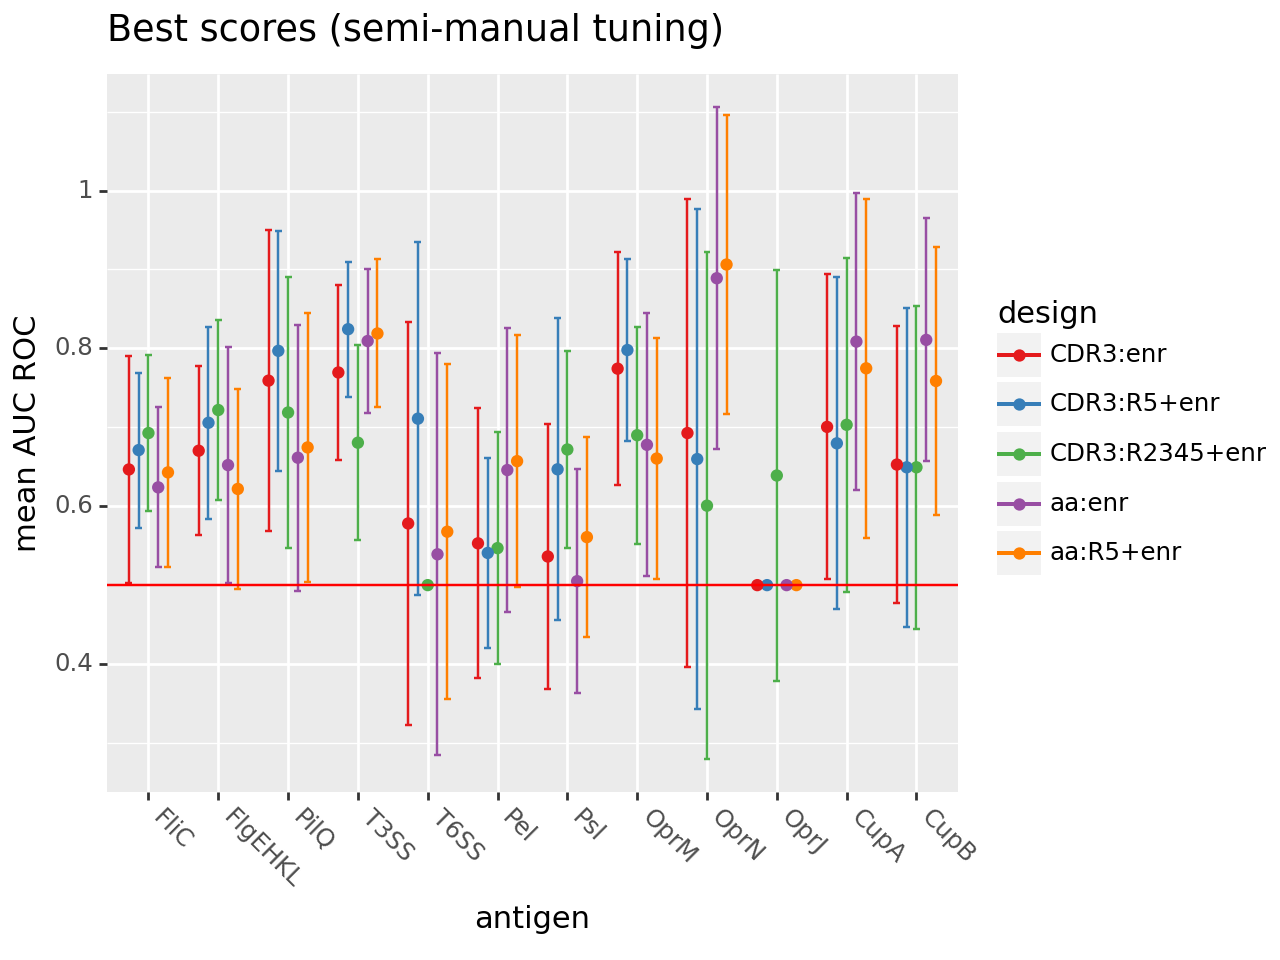

<Figure Size: (640 x 480)>

In [35]:
(plot_best_scores_by_ag_design(best_scores.reset_index(), groupby='antigen') +
 ggtitle('Best scores (semi-manual tuning)'))

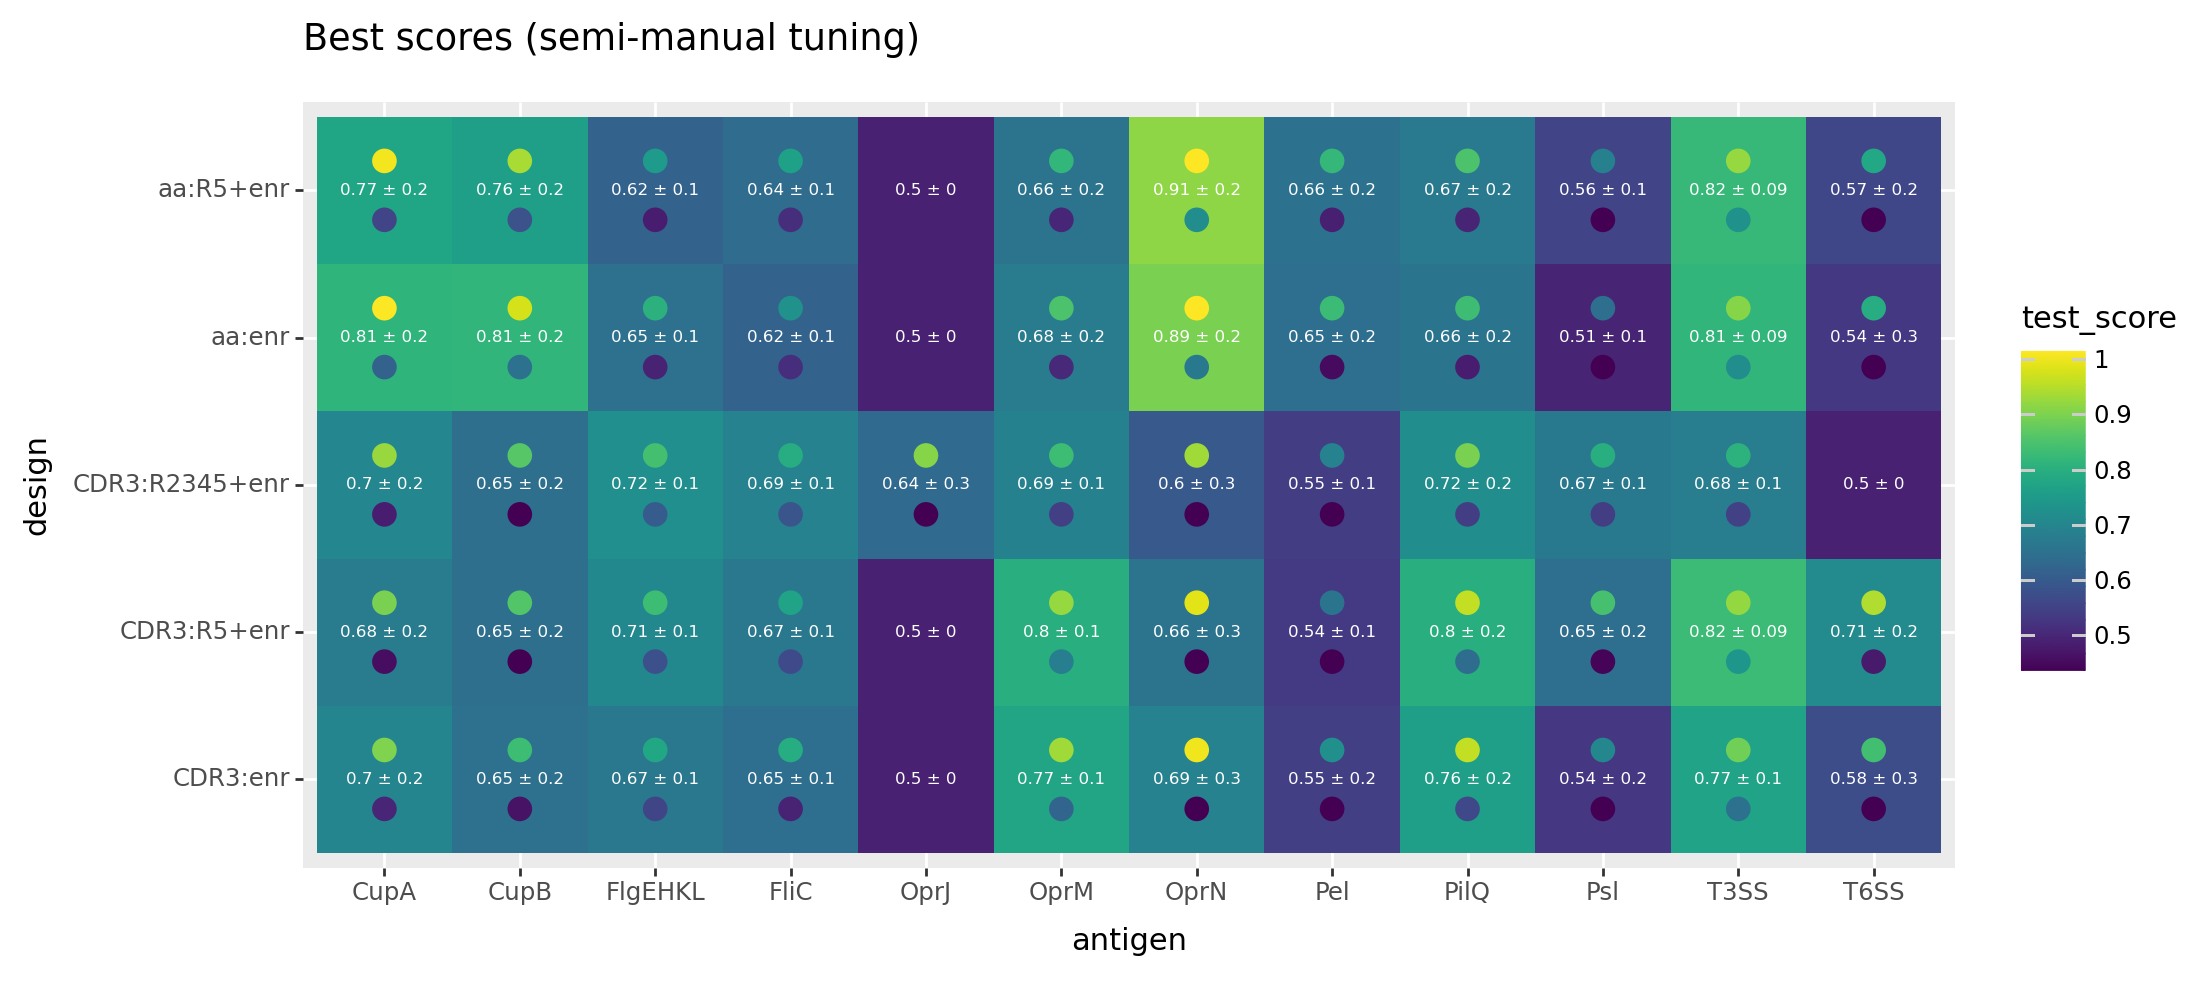

<Figure Size: (1100 x 500)>

In [36]:
(plot_best_score_heatmap(best_scores.reset_index()) +
 ggtitle('Best scores (semi-manual tuning)'))

In [37]:
# best_scores.reorder_levels(['antigen','design']).sort_index()

In [38]:
def plot_n_label(df, x='n_label', title='number of samples'):
    import warnings
    df = pd.merge(left=df, left_on='antigen', right=n_labels_01, right_index=True)
    xlim = np.percentile(df[x], 90)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        display(
            ggplot(df, aes(x=x, y='mean_test_score', color='antigen')) 
            + geom_point() 
            + geom_text(aes(label='antigen'), ha='left', position=position_nudge(x=1)) 
            + facet_grid(('.', 'design')) 
            + theme(figure_size=(15,3), legend_position='none')
            + scale_y_continuous(name="mean test score")
            + scale_x_continuous(name=title, expand=(0.2,0))
            + coord_cartesian(xlim=(0, xlim))
        )

Uncomment to plot (number of samples) versus (mean model AUROC), for each antigen, for each dataset

In [39]:
# plot_n_label(best_scores.reset_index())
# plot_n_label(best_scores.reset_index(),'n_label_0', title='number of antigen- samples')
# plot_n_label(best_scores.reset_index(),'n_label_1', title='number of antigen+ samples')

### Bayesian Hyperparameter optimization

In [40]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [41]:
bayes = {}
index = list(itertools.product(datasets, antigens))

best_scores_bayes = []
best_params_bayes = []
all_params_bayes = []
for dataset, ag in index:
    with open(f'results/learning/xgb/bayes/{dataset}/{ag}.pickle', 'rb') as f:
        out = pickle.load(f) 
    bayes[(dataset, ag)] = out
    best_params_bayes.append(out['estimator'].best_params_)
    scores = pd.DataFrame(out['estimator'].cv_results_).sort_values('rank_test_score')
    best_scores_bayes.append(scores.iloc[0,:].copy())
    
    scores['antigen'] = ag
    scores['design'] = dataset
    all_params_bayes.append(scores)
    

best_scores_bayes = pd.DataFrame(best_scores_bayes, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
best_params_bayes = pd.DataFrame(best_params_bayes, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
all_params_bayes = pd.concat(all_params_bayes)
all_params_bayes['strategy'] = 'bayes'

Uncomment to visualize performance of all tested hyperparameter combinations, ranked best to worst, for each antigen for each dataset:

In [42]:
# plot_all_params(all_params_bayes)

Uncomment to visualize heatmap showing result of various hyperparameters across different datasets

In [43]:
# plot_param_heatmap(best_params_bayes, ncols=2, columns=['max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'gamma', 'reg_alpha'])

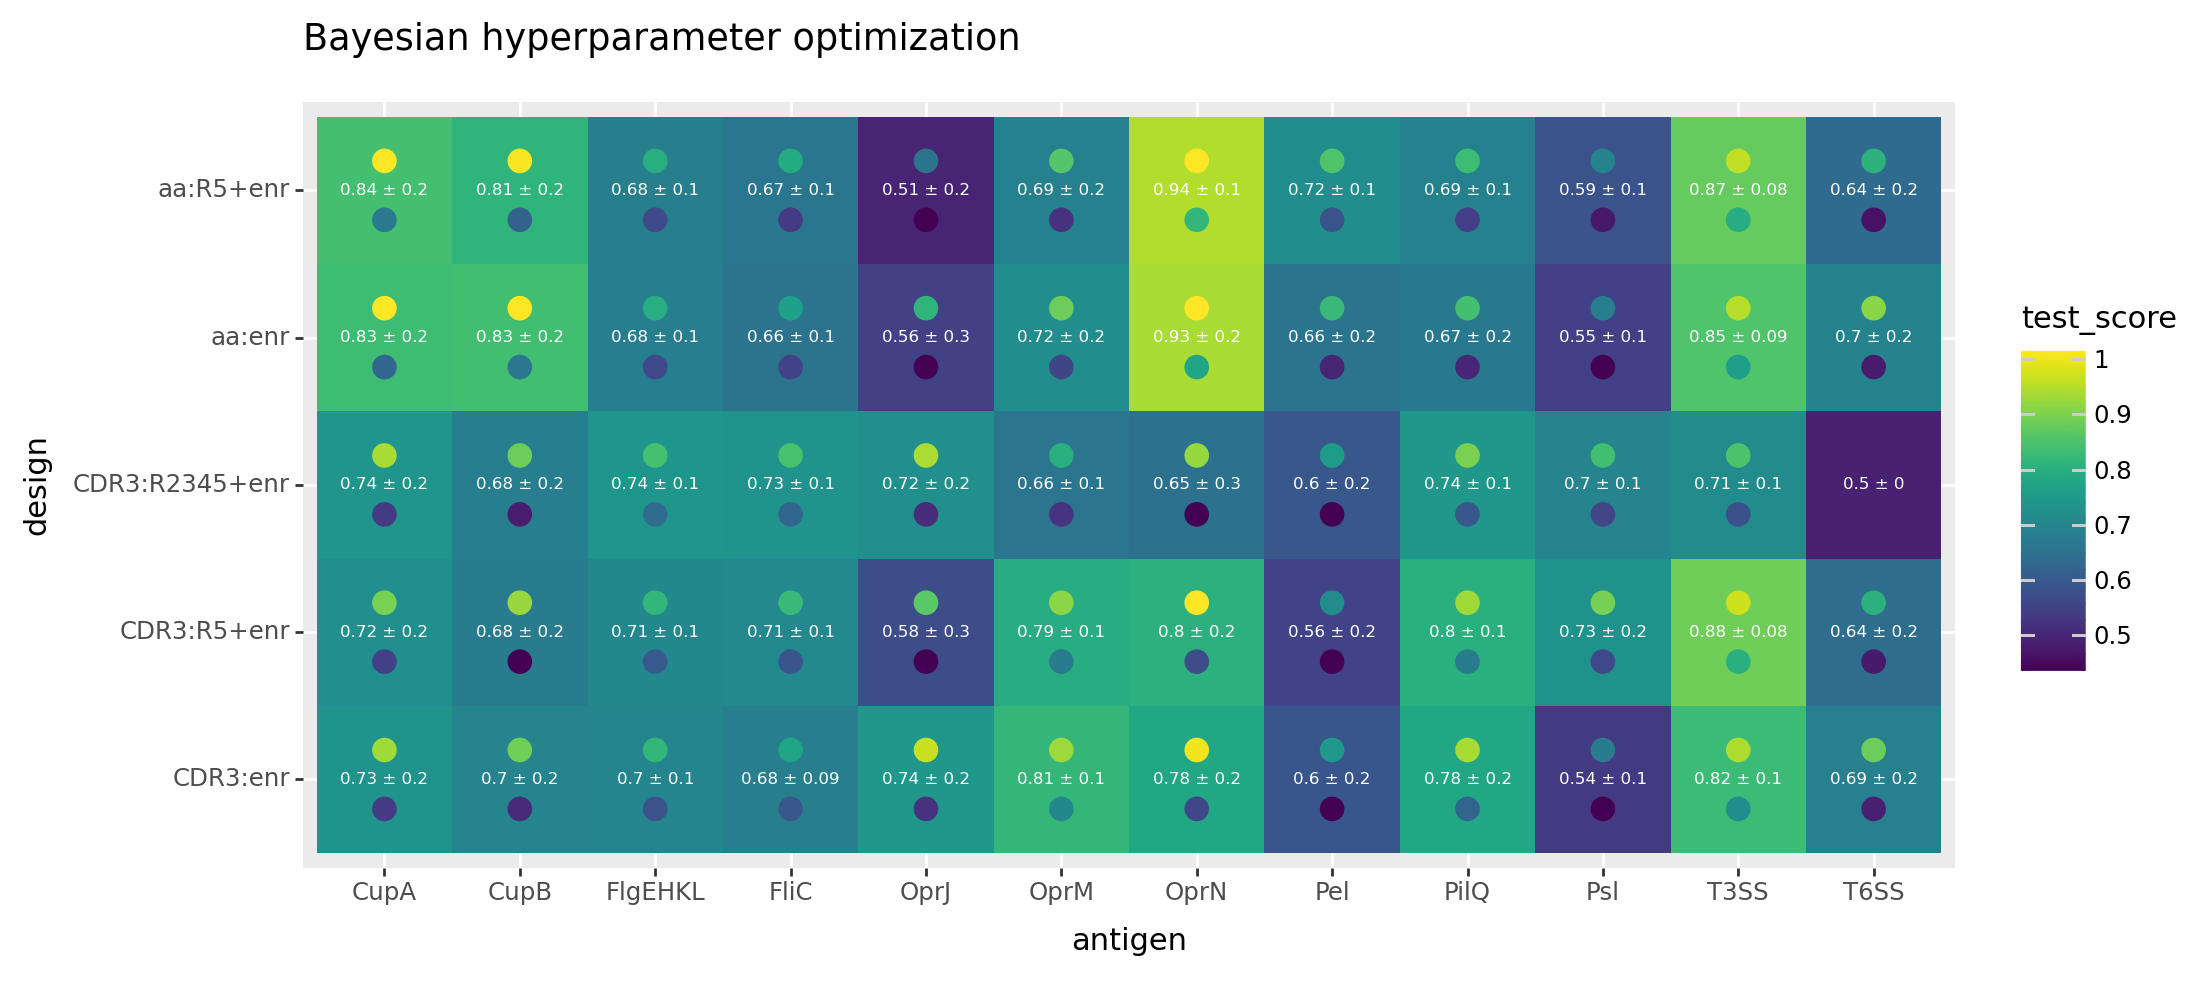

<Figure Size: (1100 x 500)>

In [44]:
(plot_best_score_heatmap(best_scores_bayes.reset_index()) + ggtitle('Bayesian hyperparameter optimization'))

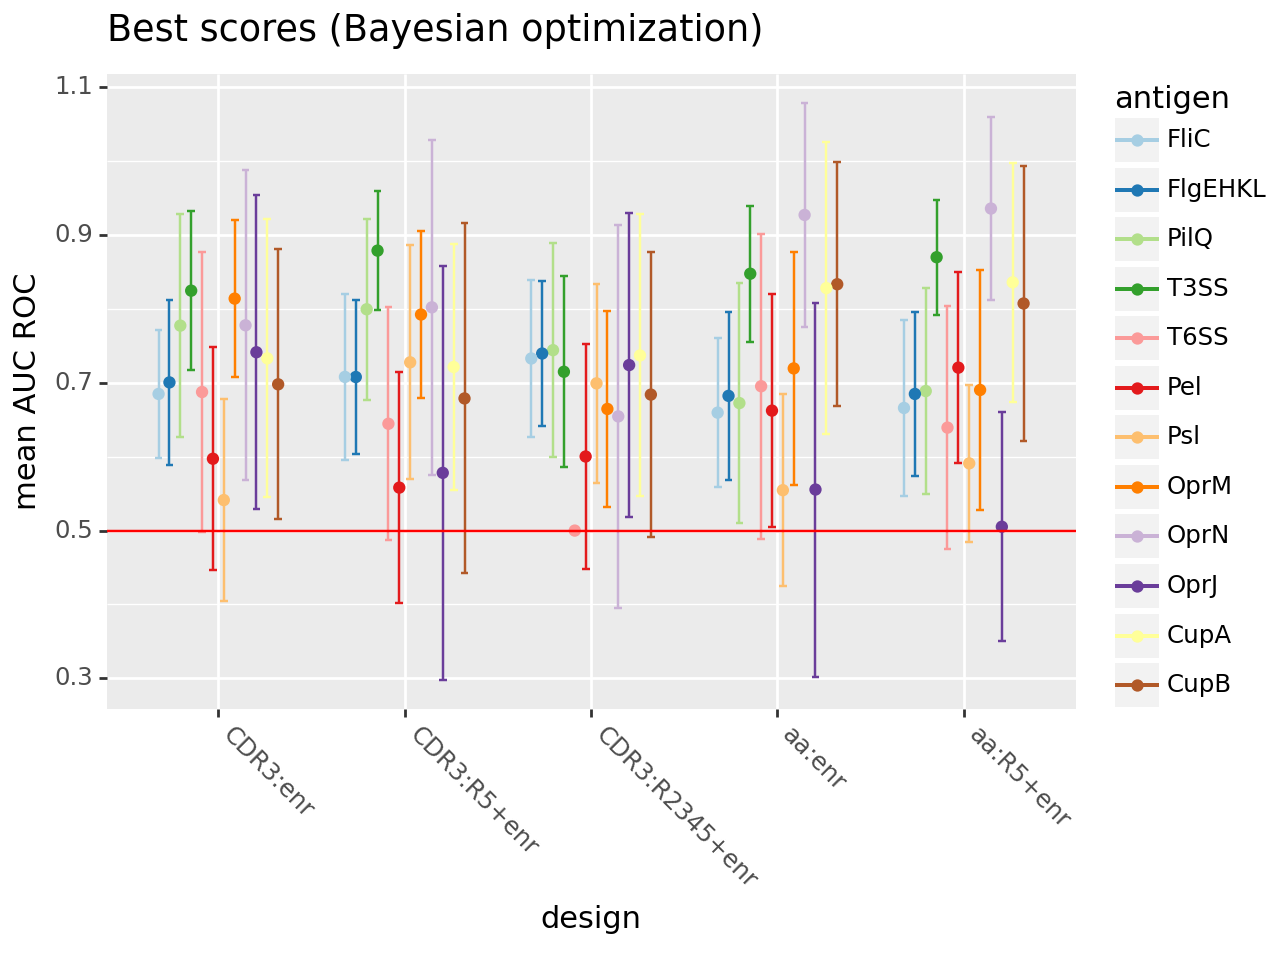

<Figure Size: (640 x 480)>

In [45]:
plot_best_scores_by_ag_design(best_scores_bayes.reset_index()) + ggtitle('Best scores (Bayesian optimization)')

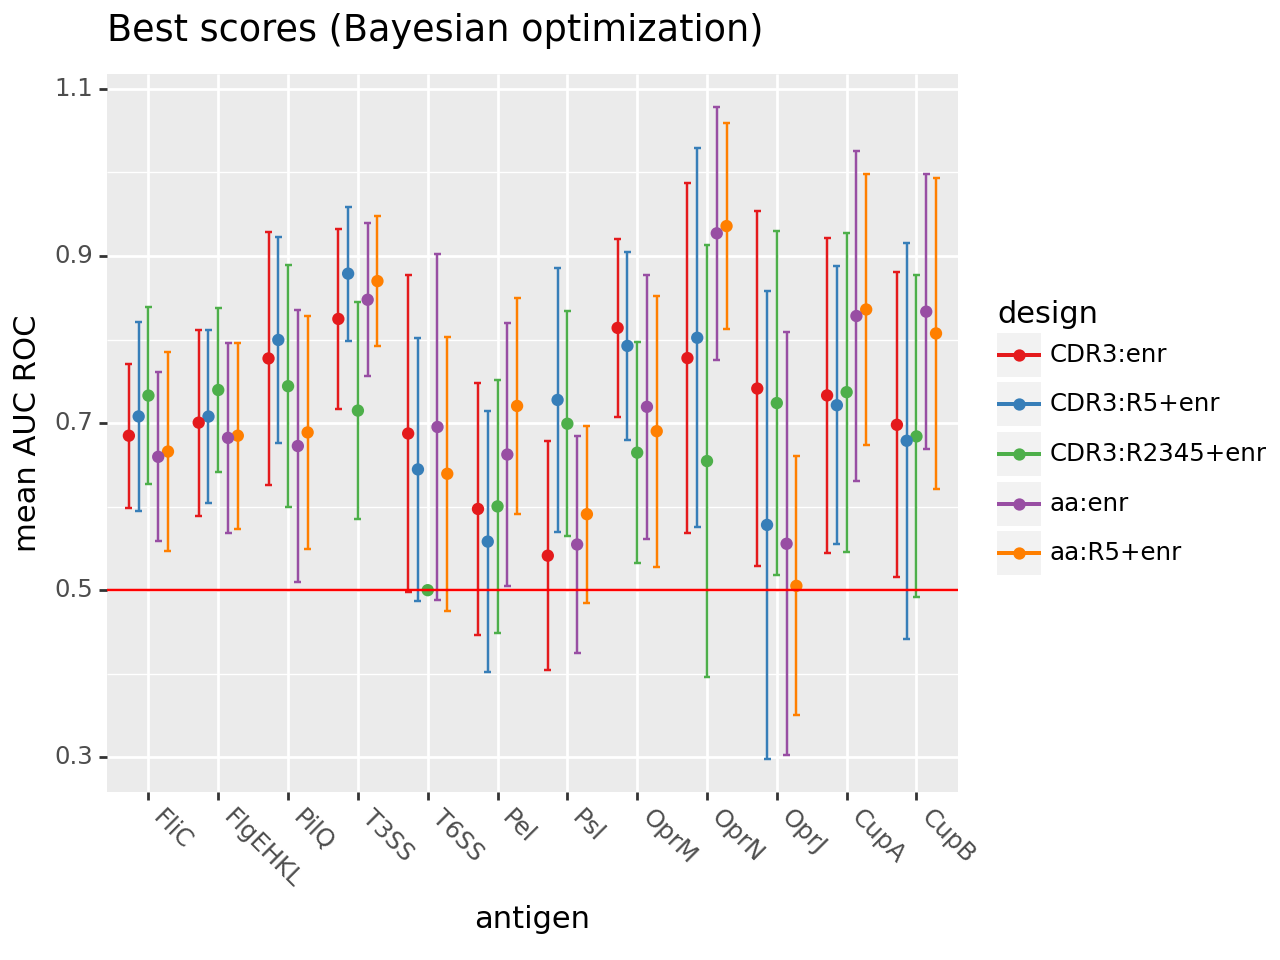

<Figure Size: (640 x 480)>

In [46]:
plot_best_scores_by_ag_design(best_scores_bayes.reset_index(),groupby='antigen') + ggtitle('Best scores (Bayesian optimization)')

Uncomment to plot (number of samples) versus (mean model AUROC), for each antigen, for each dataset

In [47]:
# plot_n_label(best_scores_bayes.reset_index())
# plot_n_label(best_scores_bayes.reset_index(),'n_label_0', title='number of antigen- samples')
# plot_n_label(best_scores_bayes.reset_index(),'n_label_1', title='number of antigen+ samples')

In [48]:
def plot_objective_design_ag(design, antigen):
    from skopt.plots import plot_objective, plot_histogram

    # monkey patch to make skopt work
    np.int = int

    search = bayes[(design, antigen)]['estimator']
    plot_objective(search.optimizer_results_[0], dimensions=list(search.search_spaces.keys()));
    plt.suptitle(f"{antigen}\n{design}")

Uncomment to visualize the estimated objective space. Plots a matrix of "partial dependence plots," each of which shows the effect of a search space dimension (hyperparameter) or pair of dimensions on the objective function (model performance, i.e. AUROC).

In [49]:
# plot_objective_design_ag('CDR3:R5+enr','OprM')

# plot_objective_design_ag('CDR3:R5+enr','T3SS')

# plot_objective_design_ag('CDR3:R5+enr','FlgEHKL')

### Random Hyperparameter Search

In [50]:
random = {}
index = list(itertools.product(datasets, antigens))

best_scores_random = []
best_params_random = []
all_params_random = []
for dataset, ag in index:
    with open(f'results/learning/xgb/random/{dataset}/{ag}.pickle', 'rb') as f:
        out = pickle.load(f) 
    random[(dataset, ag)] = out
    best_params_random.append(out['estimator'].best_params_)
    scores = pd.DataFrame(out['estimator'].cv_results_).sort_values('rank_test_score')
    best_scores_random.append(scores.iloc[0,:].copy())
    
    scores['antigen'] = ag
    scores['design'] = dataset
    all_params_random.append(scores)
    

best_scores_random = pd.DataFrame(best_scores_random, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
best_params_random = pd.DataFrame(best_params_random, index=pd.MultiIndex.from_tuples(index, names=['design', 'antigen'])) #.reorder_levels(['antigen','design']).sort_index()
all_params_random = pd.concat(all_params_random)
all_params_random['strategy'] = 'random'

Uncomment to visualize performance of all tested hyperparameter combinations, ranked best to worst, for each antigen for each dataset:

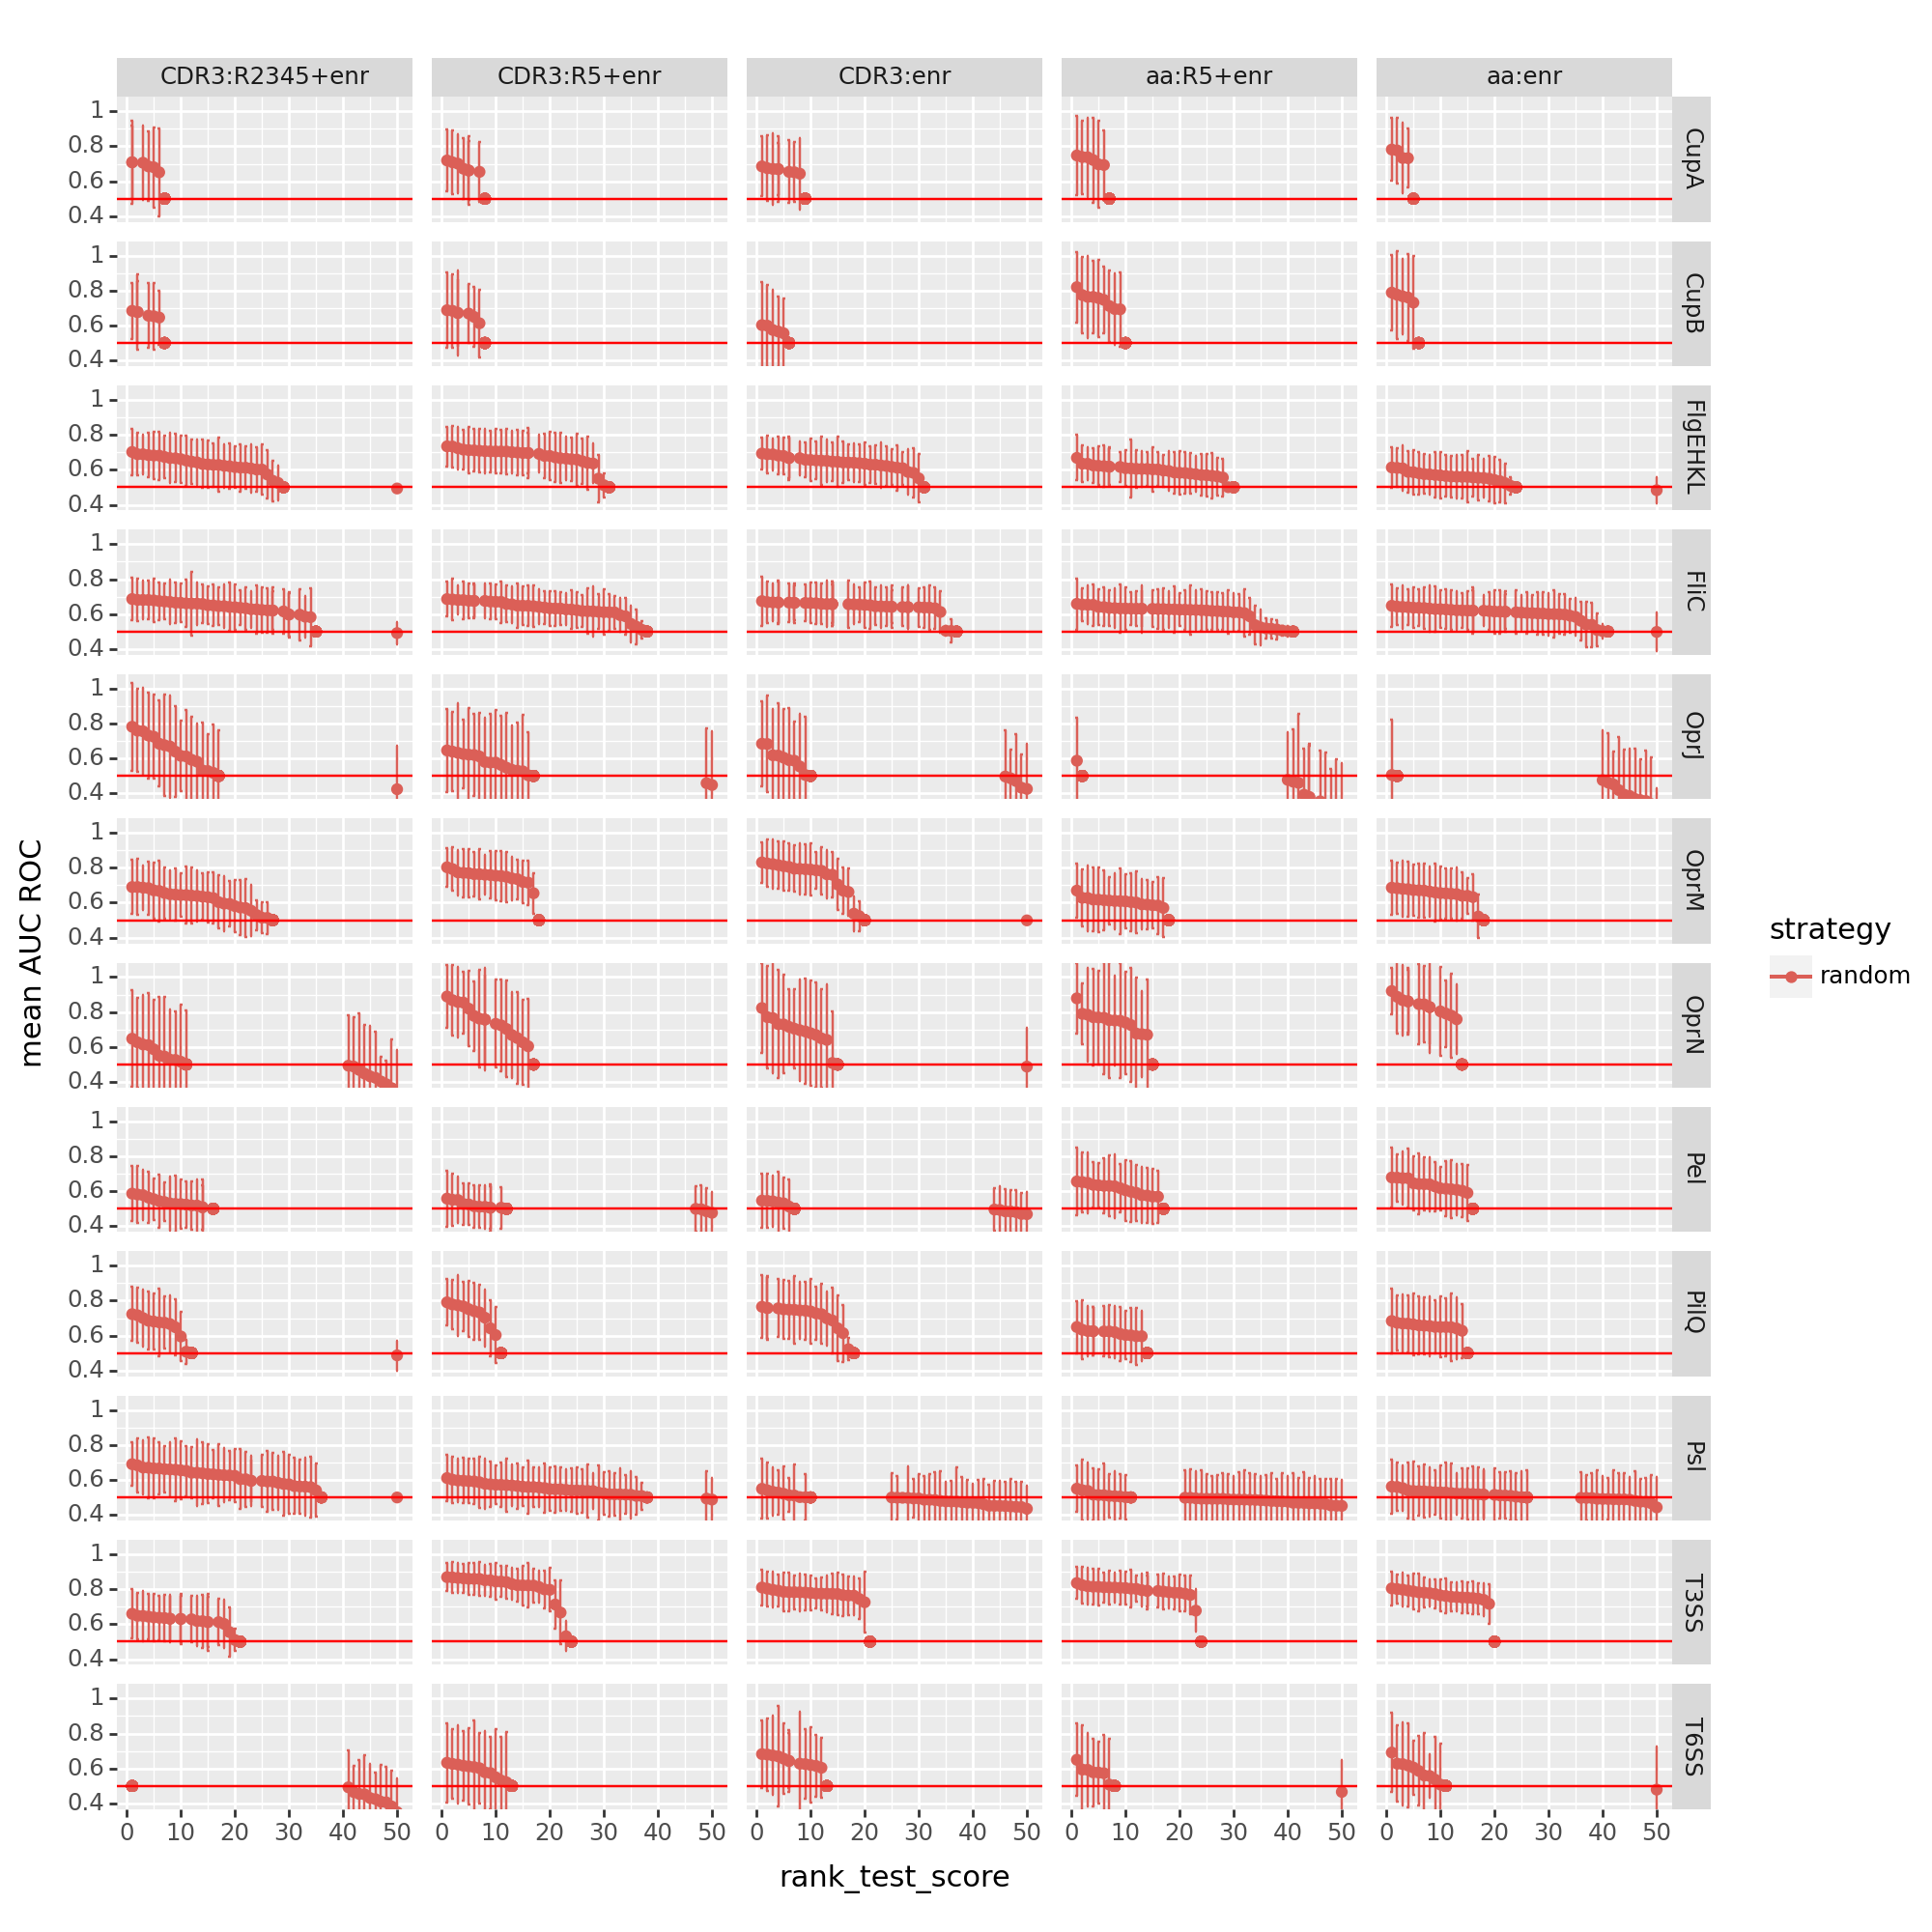

<Figure Size: (1000 x 1000)>

In [51]:
plot_all_params(all_params_random)

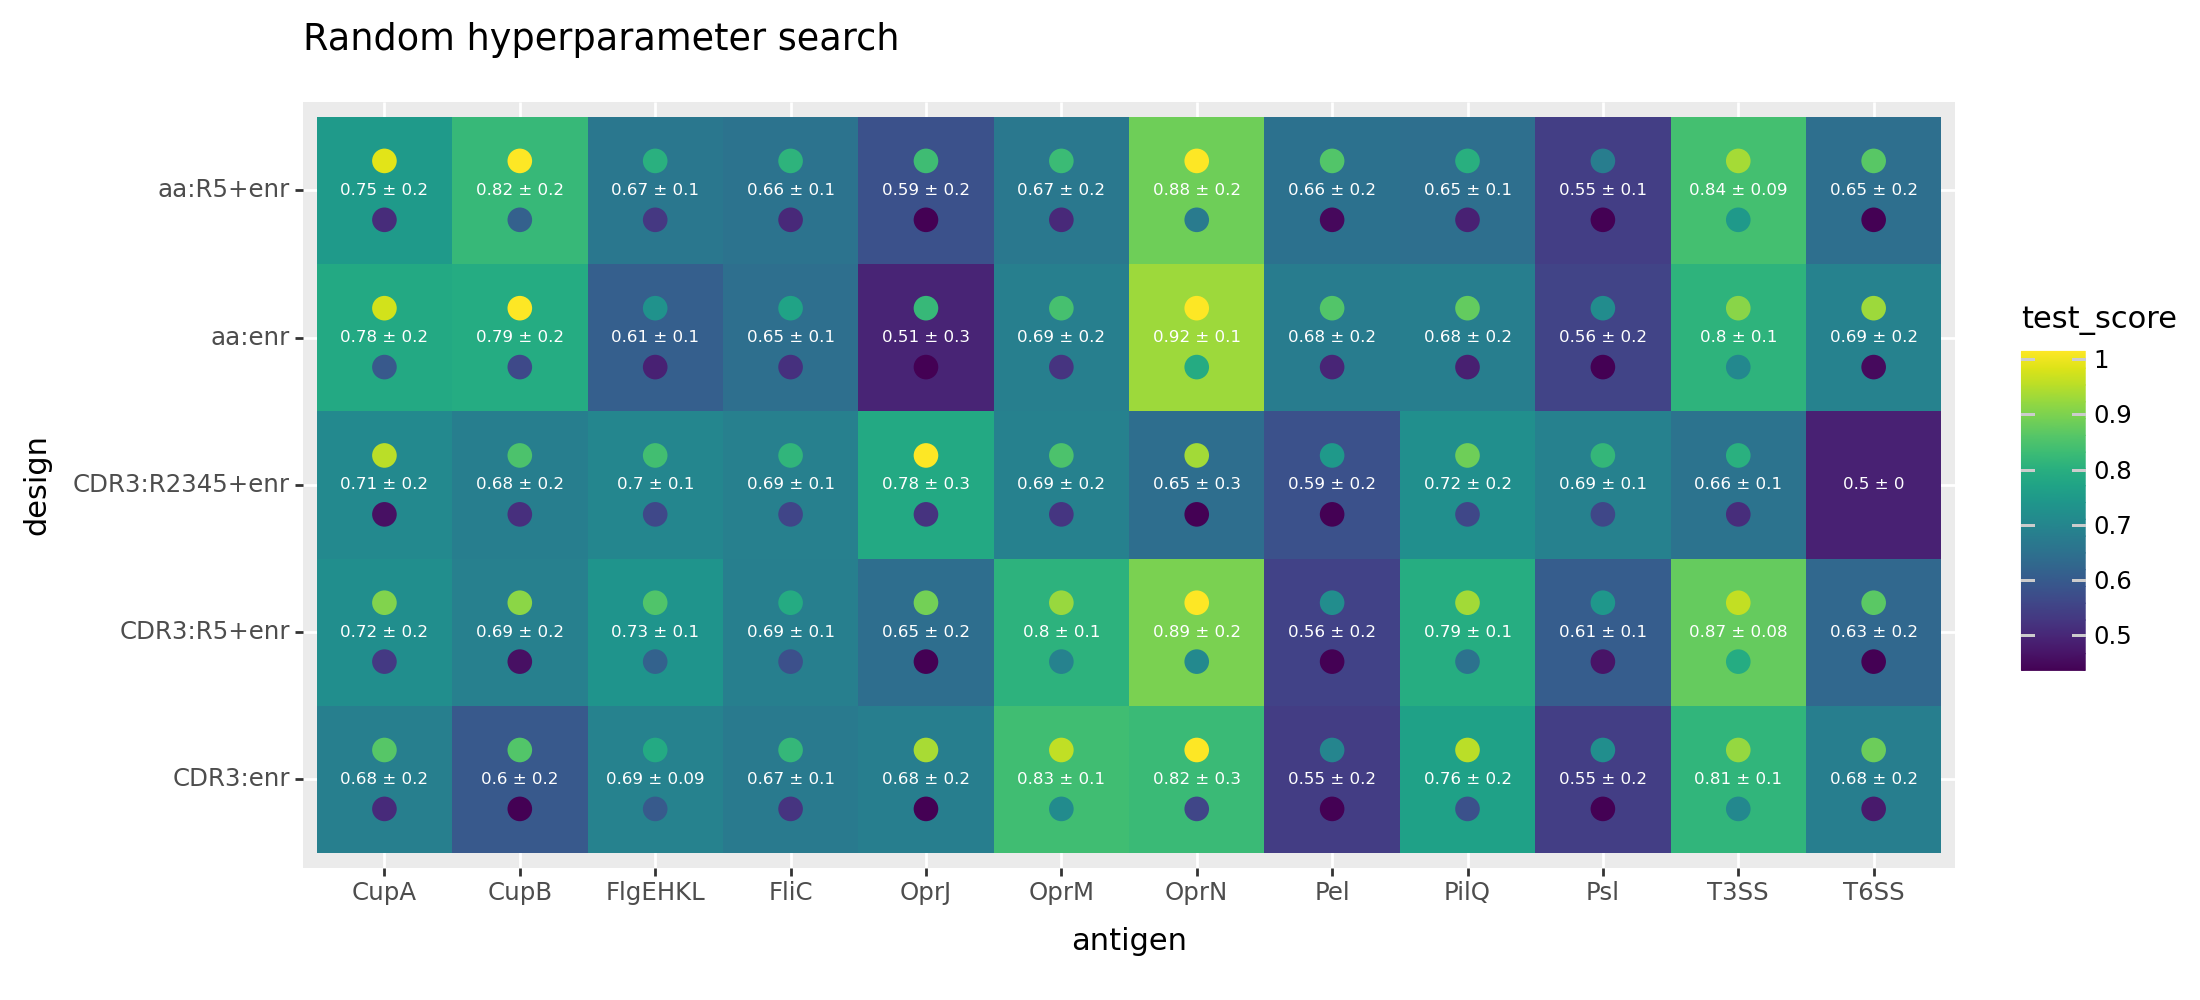

<Figure Size: (1100 x 500)>

In [52]:
(plot_best_score_heatmap(best_scores_random.reset_index()) + ggtitle('Random hyperparameter search'))

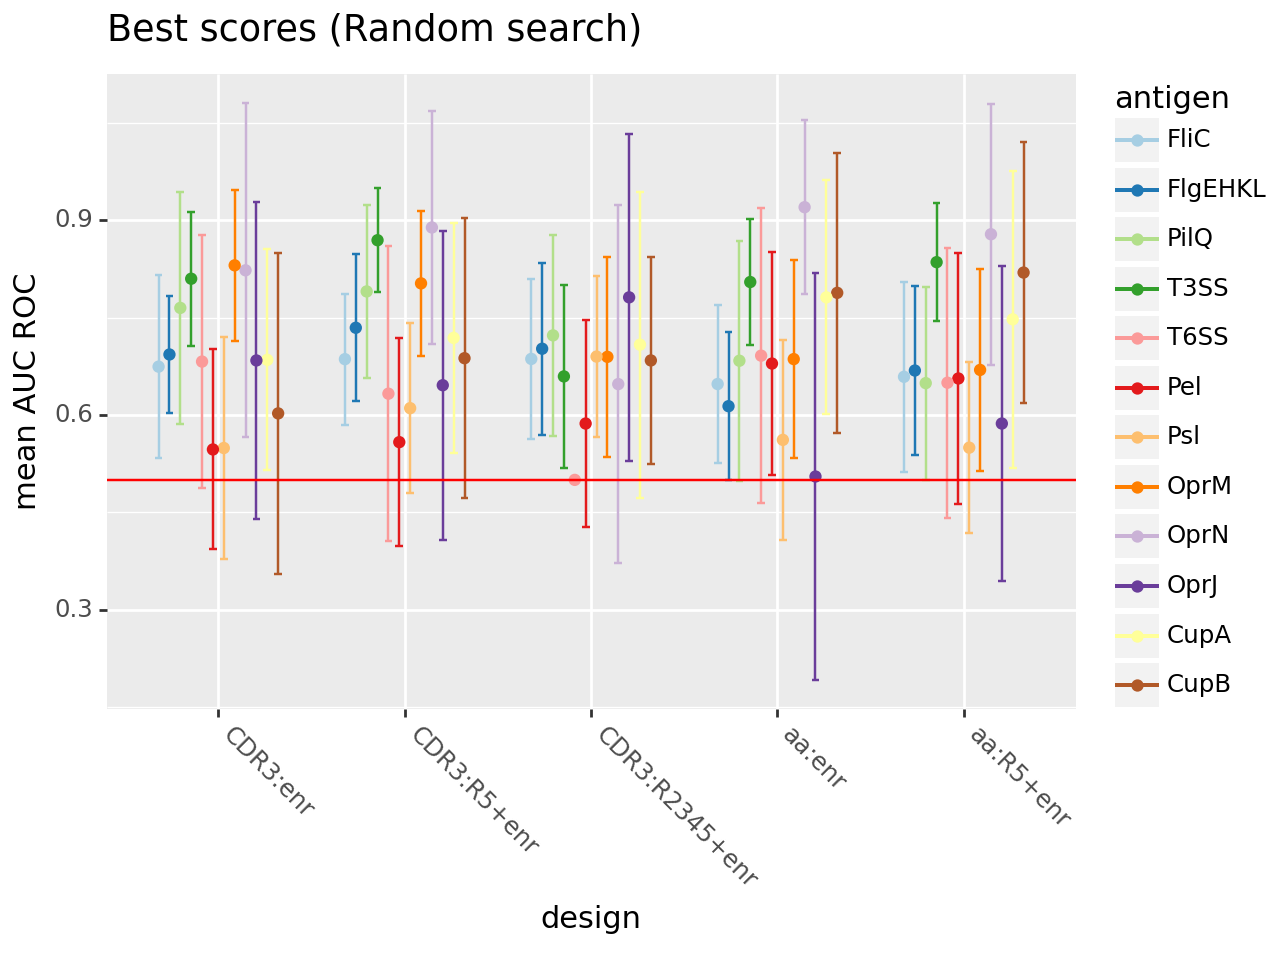

<Figure Size: (640 x 480)>

In [53]:
plot_best_scores_by_ag_design(best_scores_random.reset_index()) + ggtitle('Best scores (Random search)')

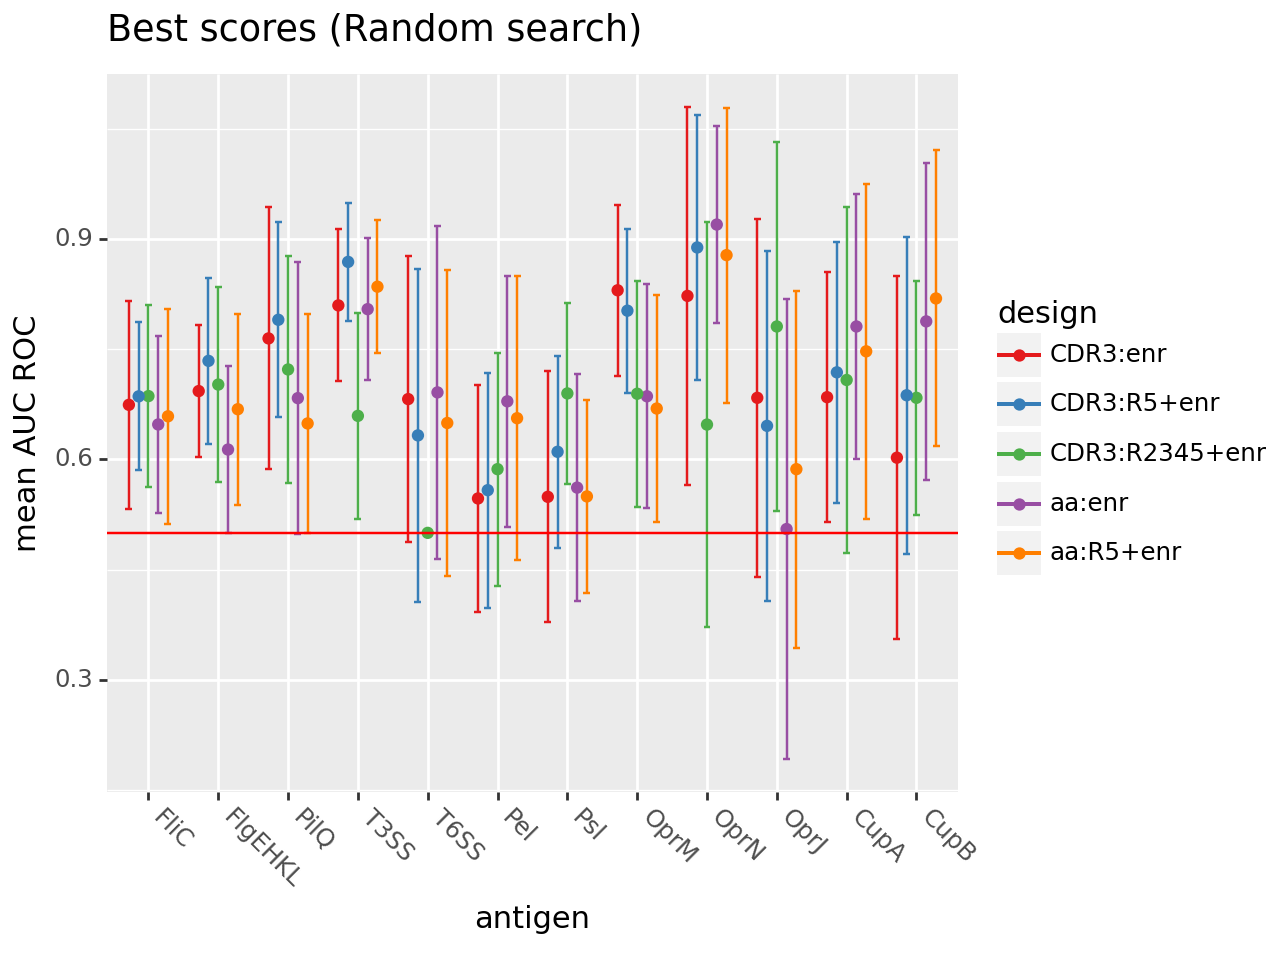

<Figure Size: (640 x 480)>

In [54]:
plot_best_scores_by_ag_design(best_scores_random.reset_index(),groupby='antigen') + ggtitle('Best scores (Random search)')

## Best parameters overall

In [55]:
best_scores_bayes['strategy'] = 'bayes'
best_scores_random['strategy'] = 'random'
best_scores['strategy'] = 'manual'

In [56]:
all_scores = pd.concat([
    best_scores.reset_index(),
    best_scores_bayes.reset_index(),
    best_scores_random.reset_index()
]).reset_index(drop=True)
all_scores.index.rename('index', inplace=True)

# best_param_idxs = all_scores.sort_values('mean_test_score').groupby(['antigen','strategy'])['mean_test_score'].nlargest(1).reset_index()['index']
best_param_idxs = all_scores.sort_values('mean_test_score').groupby(['antigen'])['mean_test_score'].nlargest(1).reset_index()['index']
best_params_overall = all_scores.loc[best_param_idxs, :].set_index('antigen')

In [57]:
best_param_idxs = all_scores.sort_values('mean_test_score').groupby(['antigen','strategy'])['mean_test_score'].nlargest(1).reset_index()['index']
best_params_by_strategy = all_scores.loc[best_param_idxs, :].set_index('antigen')

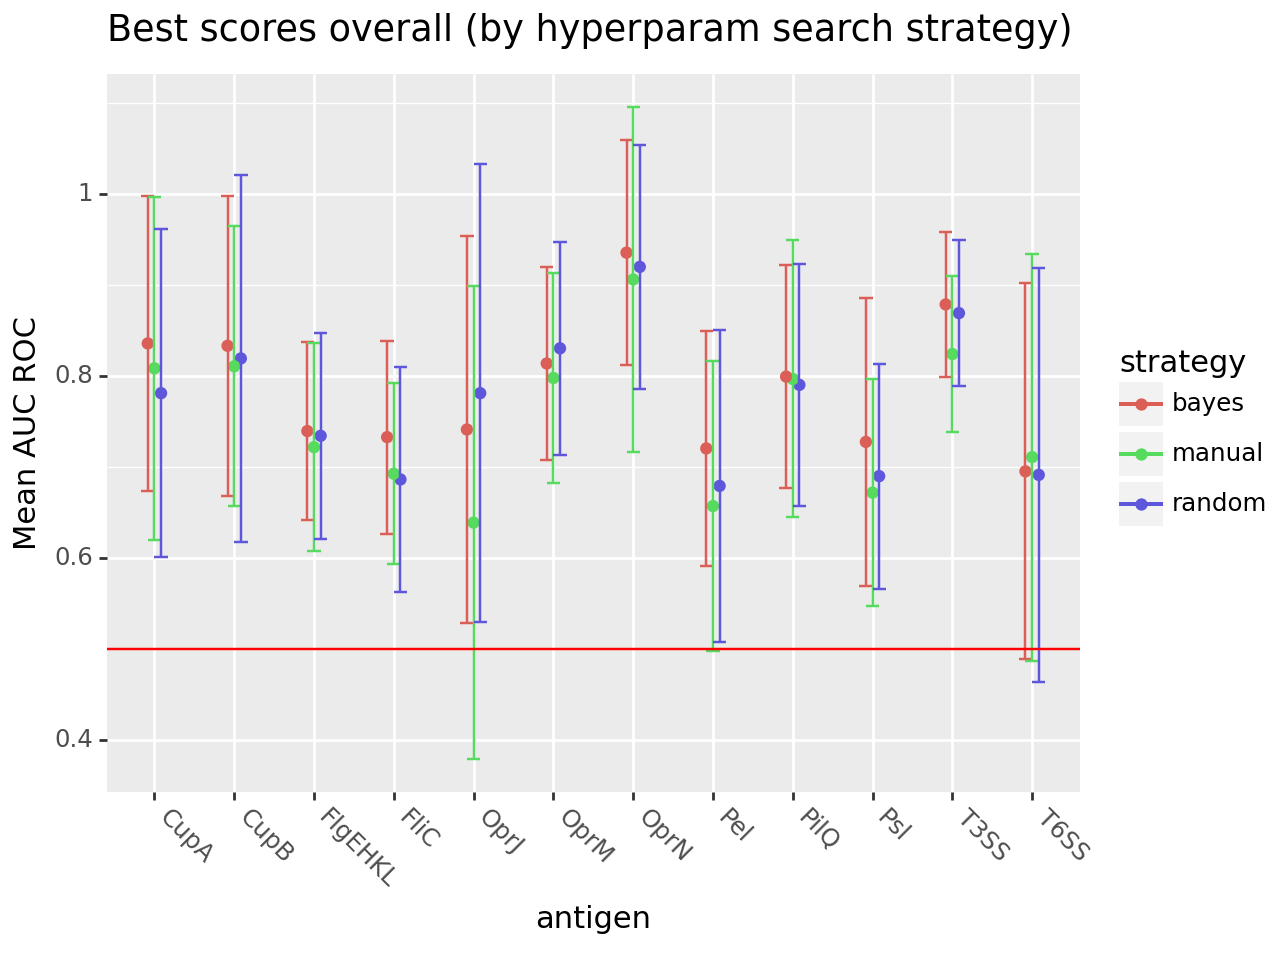

<Figure Size: (640 x 480)>

In [58]:
dodge = position_dodge(width=0.25)
(ggplot(best_params_by_strategy.reset_index(), 
        aes(x='antigen', y='mean_test_score', ymax='mean_test_score+std_test_score', ymin='mean_test_score-std_test_score', color='strategy')) + 
 geom_point(position=dodge) + 
 geom_errorbar(position=dodge) + geom_hline(yintercept=0.5, color='red') + 
 theme(axis_text_x=element_text(rotation=-45, hjust=0)) +
 scale_y_continuous(name="Mean AUC ROC") +
 ggtitle("Best scores overall (by hyperparam search strategy)")
)
# sns.catplot(data=best_params_overall.reset_index(), x='antigen', y='mean_test_score')

In [59]:
best_param_idxs = all_scores.sort_values('mean_test_score').groupby(['antigen','design'])['mean_test_score'].nlargest(1).reset_index()['index']
best_params_by_dataset = all_scores.loc[best_param_idxs, :].set_index('antigen')

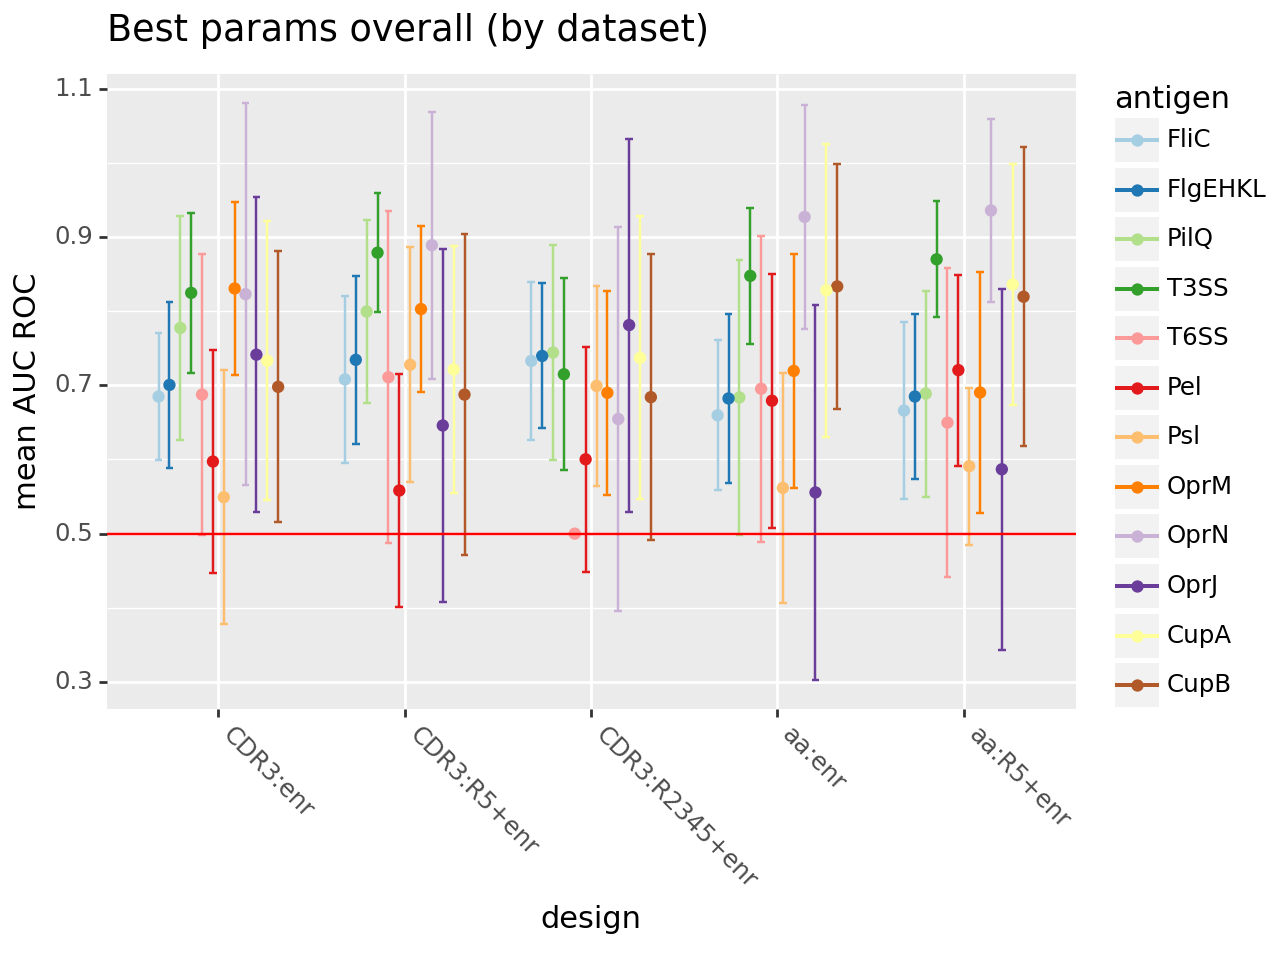

<Figure Size: (640 x 480)>

In [60]:
plot_best_scores_by_ag_design(best_params_by_dataset.reset_index()) + ggtitle("Best params overall (by dataset)")

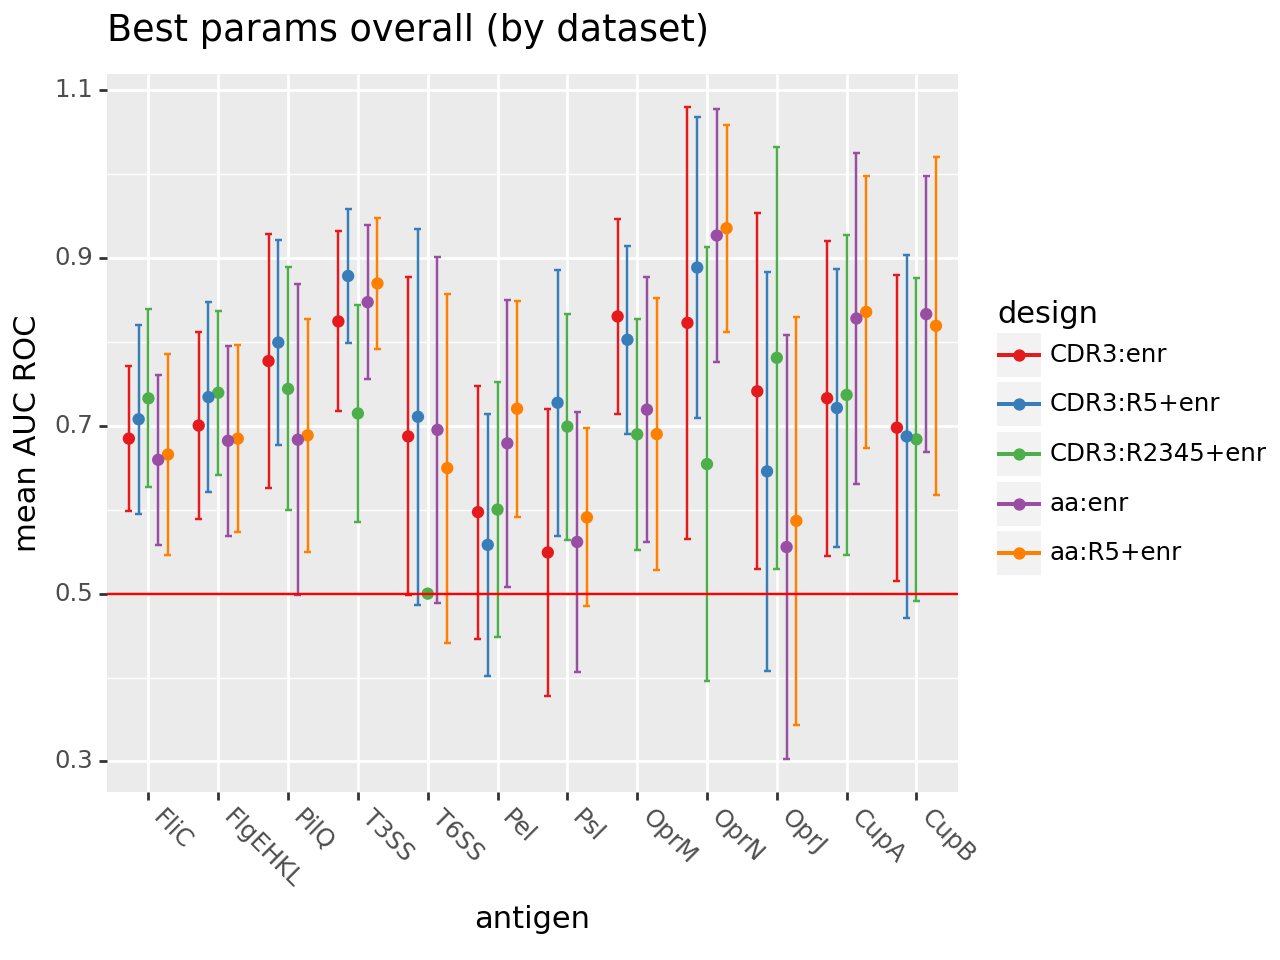

<Figure Size: (640 x 480)>

In [61]:
plot_best_scores_by_ag_design(best_params_by_dataset.reset_index(), groupby='antigen') + ggtitle("Best params overall (by dataset)")

### Fit Models with optimized hyperparameters

Now, for each antigen, fit a model using the best dataset and the best hyperparameters

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit

def plot_best_params_overall(ag, cv=None, verbose=True, figsize=2, plot_kws=None, **kwargs):
    design = best_params_overall.loc[ag, 'design']
    strategy = best_params_overall.loc[ag, 'strategy']
    title = f"{ag} -> {design} ({strategy})"
    print(title)
    print("="*len(title))
    print()
    
    # params = { **best_params_overall.loc[ag, 'params'], **{'learning_rate': 0.025} }
    params = { **best_params_overall.loc[ag, 'params'], **{'learning_rate': 0.01}, **kwargs }
    model = xgb.XGBClassifier(use_label_encoder=False, n_jobs=1, tree_method='hist', eval_metric='logloss', **params)
    # print(model)
    
    if cv is None:
        cv = StratifiedShuffleSplit(n_splits=48, test_size=0.3, random_state=42)
    # print(cv)

    # shuffles = [False, 'labels', 'rows']
    shuffles = [False, 'labels']
    fig, axs = plt.subplots(ncols=len(shuffles), figsize=(figsize*len(shuffles)*0.95, figsize))
    if plot_kws is None:
        plot_kws = dict()
    plot_kws = {'legend':'text', **plot_kws}
    out = {}
    for i, shuffle in enumerate(shuffles):
        _out = fit_and_test_model_antigen(
            designs[design], ag_matrix, ag=ag,
            aggregate_folds=False, 
            shuffle=shuffle,
            model = model,
            cv=cv, 
            n_jobs=-1, verbose=verbose, plot=True, ax=axs[i], 
            plot_kws = plot_kws)
        print()
        if not shuffle:
            out['true'] = _out
        else:
            axs[i].yaxis.set_ticklabels([])
            axs[i].set_ylabel("")
            out['shuffle'] = _out
    plt.tight_layout()
    print()
    return out

In [63]:
%%bash
mkdir -p results/plots/learning/roc/
mkdir -p results/tables/figures/learning/roc

In [64]:
# silence numerous matplotlib warnings
plt.set_loglevel('error')

In [65]:
# silence xgboost deprecation warnings
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [66]:
_antigens = ['FlgEHKL', 'PilQ', 'OprM', 'T3SS']

FlgEHKL -> CDR3:R2345+enr (bayes)

FlgEHKL : # samples = 
    FlgEHKL
    0    34
    1    19
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8939461840817361, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.16894656933025087, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
StratifiedShuffleSplit(n_splits=48, random_state=42, test_size=

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.71 ± 0.10
  AUC < 0.5, p = 1.1105444e-09 (U = 136991; Mann-Whitney U, alternative = greater)
Accuracy = 0.61 ± 0.49
  accuracy < 0.5, p = 1.0396191e-10 (t-test, alternative = greater)

FlgEHKL SHUFFLE labels : # samples = 
    FlgEHKL
    0    34
    1    19
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8939461840817361, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.16894656933025087, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
          

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.54 ± 0.12
  AUC < 0.5, p = 0.1770335 (U = 114683; Mann-Whitney U, alternative = greater)
Accuracy = 0.61 ± 0.49
  accuracy < 0.5, p = 1.68855e-10 (t-test, alternative = greater)


results/tables/figures/learning/roc/FlgEHKL.csv
results/plots/learning/roc/FlgEHKL.svg



PilQ -> CDR3:R5+enr (bayes)

PilQ : # samples = 
    PilQ
    1    20
    0    12
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9250945135993665, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0002979045267098278, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_le

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.76 ± 0.17
  AUC < 0.5, p = 6.8661807e-07 (U = 83493; Mann-Whitney U, alternative = greater)
Accuracy = 0.74 ± 0.44
  accuracy < 0.5, p = 9.6520235e-29 (t-test, alternative = greater)

PilQ SHUFFLE labels : # samples = 
    PilQ
    1    20
    0    12
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9250945135993665, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0002979045267098278, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.54 ± 0.19
  AUC < 0.5, p = 0.21327966 (U = 71487; Mann-Whitney U, alternative = greater)
Accuracy = 0.57 ± 0.49
  accuracy < 0.5, p = 0.00048362101 (t-test, alternative = greater)


results/tables/figures/learning/roc/PilQ.csv
results/plots/learning/roc/PilQ.svg



OprM -> CDR3:enr (random)

OprM : # samples = 
    OprM
    1    29
    0    16
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8173116443179708, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0004045268180269963, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=N

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.75 ± 0.14
  AUC < 0.5, p = 2.0792221e-06 (U = 168953; Mann-Whitney U, alternative = greater)
Accuracy = 0.74 ± 0.44
  accuracy < 0.5, p = 3.7285562e-39 (t-test, alternative = greater)

OprM SHUFFLE labels : # samples = 
    OprM
    1    29
    0    16
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8173116443179708, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0004045268180269963, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.42 ± 0.14
  AUC < 0.5, p = 0.93291768 (U = 137408; Mann-Whitney U, alternative = greater)
Accuracy = 0.57 ± 0.5
  accuracy < 0.5, p = 0.00024730848 (t-test, alternative = greater)


results/tables/figures/learning/roc/OprM.csv
results/plots/learning/roc/OprM.svg



T3SS -> CDR3:R5+enr (bayes)

T3SS : # samples = 
    T3SS
    0    23
    1    21
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8447957035481697, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.84 ± 0.11
  AUC < 0.5, p = 6.341737e-19 (U = 151277; Mann-Whitney U, alternative = greater)
Accuracy = 0.81 ± 0.4
  accuracy < 0.5, p = 5.1273658e-71 (t-test, alternative = greater)

T3SS SHUFFLE labels : # samples = 
    T3SS
    0    23
    1    21
(Setting `scale_pos_weight` to sqrt(# neg / # pos))
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8447957035481697, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
    

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq-xgb/lib/python3.10/site-p

AUC = 0.45 ± 0.14
  AUC < 0.5, p = 0.96284839 (U = 105120; Mann-Whitney U, alternative = greater)
Accuracy = 0.47 ± 0.5
  accuracy < 0.5, p = 0.94737958 (t-test, alternative = greater)


results/tables/figures/learning/roc/T3SS.csv
results/plots/learning/roc/T3SS.svg




results/tables/figures/learning/roc_p_values.csv

results/learning/best_models.csv


,design,strategy,objective,use_label_encoder,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,...,predictor,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
FlgEHKL,CDR3:R2345+enr,bayes,binary:logistic,False,None,None,None,None,None,0.893946,...,None,None,0.000062,None,None,1.789474,0.646570,hist,None,None
PilQ,CDR3:R5+enr,bayes,binary:logistic,False,None,None,None,None,None,0.925095,...,None,None,0.000672,None,None,0.600000,1.000000,hist,None,None
OprM,CDR3:enr,random,binary:logistic,False,None,None,None,None,None,0.817312,...,None,None,0.015668,None,None,0.551724,0.537453,hist,None,None
T3SS,CDR3:R5+enr,bayes,binary:logistic,False,None,None,None,None,None,0.844796,...,None,None,0.490645,None,None,1.095238,0.500000,hist,None,None


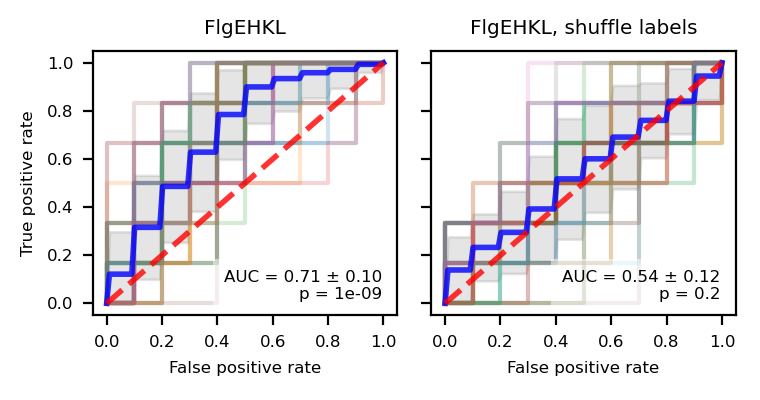

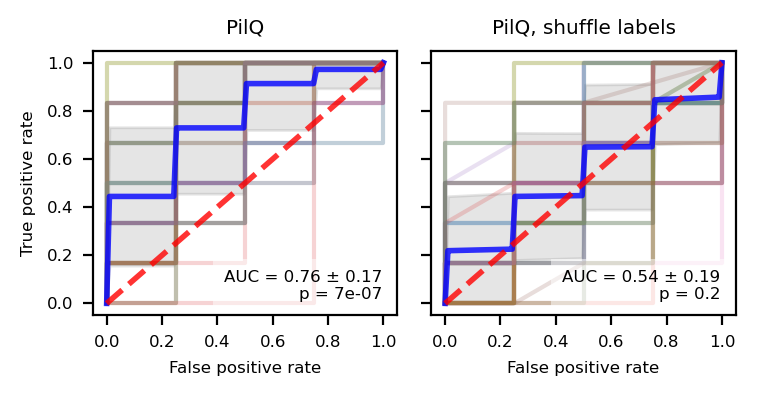

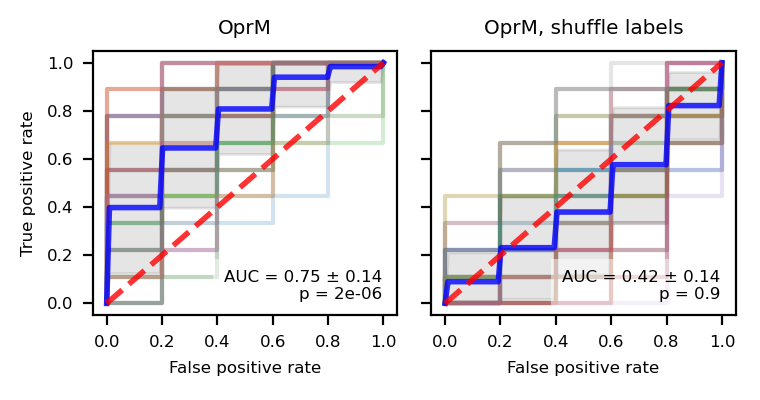

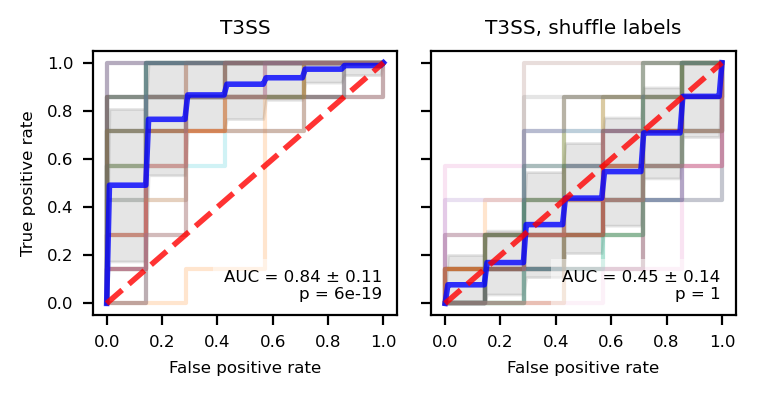

In [67]:
import pickle
models = {}

nbseq.utils.mkdirp('results/learning/best_models/')
nbseq.utils.mkdirp('results/learning/best_models/')
for ag in _antigens:
    out = plot_best_params_overall(ag);
    models[ag] = out['true']

    # gather source data for each labeling
    dfs = []
    for side in ['true','shuffle']:
        df = models[ag]['roc'].rename(columns={
            'fold': 'cross-validation fold number',
            'tpr': 'true positive rate',
            'fpr': 'false positive rate',
            'auc': 'area under curve for fold'
        }).drop(columns=['p','U'])
        df.insert(0,'labels', side)
        dfs.append(df)
    fn = f'results/tables/figures/learning/roc/{ag}.csv'
    pd.concat(dfs).to_csv(fn, index=False)
    print(fn)

    fn_fig = f'results/plots/learning/roc/{ag}.svg'
    plt.savefig(fn_fig)
    print(fn_fig)
    print("\n\n")

    # with open(f'results/learning/best_models/{ag}.pickle', 'wb') as file:
    #     pickle.dump(models[ag], file)

    # save model in XGBoost JSON format
    models[ag]['model_unknown'].save_model(f'results/learning/best_models/{ag}.json')

print()
p_values_df = pd.DataFrame([model['roc'][['p','U']].iloc[0,:] for model in models.values()], index=models.keys())
fn = f'results/tables/figures/learning/roc_p_values.csv'
p_values_df.to_csv(fn)
print(fn)
print()

models_df = pd.DataFrame([model['model_unknown'].get_params() for model in models.values()], index=models.keys())
models_df.insert(0,'design',  best_params_overall.loc[models.keys(), 'design'])
models_df.insert(1,'strategy',best_params_overall.loc[models.keys(), 'strategy'])
fn = f'results/learning/best_models.csv'
models_df.to_csv(fn)

print(fn)
models_df